# Thorough Data Wrangling to fix data problems for Transactional Retail data, and Exploratory Data Analysis


In this project, I perform a very thorough and extensive data wrangling and cleansing in 3 datasets, in order to identify any data quality problems, any inconsistency among the attributes, and perform fixes. These 3 datasets contain transactional retail data from an online electronics store located in Melbourne, Australia. The store is exclusively online, and it has 3 warehouses around Melbourne from which goods are delivered to customers. In particular, 
- For `Dirty_data` dataset, the data quality problems mainly come in the form of inconsistency of values within the attributes, as well as the interaction among the attributes themselves. I will identify all of these problems and fix them, with the help of business rules.
- For `Outlier_data` dataset, the data quality problems mainly come in the form of outliers. I will detect all of them and remove them.
- For `Missing_data` dataset, the data quality problems mainly come in the form of missing data. I will identify them and impute them with appropriate methods, with the help of business rules. 


The business rules associated with these datasets are:
- For `Dirty_data` dataset, any rows can carry **no more than 1 anomaly**. There can only be 1 anomaly in a single row and all anomalies are fixable. If there are no possible way to fix it, it is not an anomaly.
- The retail store focuses on 10 branded items and sells them at competitive prices.
- The store has different business rules depending on the season to match the different demands of each season. For example, delivery charges is calculated using a linear model which differs depending on the season. The model depends linearly on:
    - Distance between customer and nearest warehouse
    - Whether customer wants an expedited delivery
    - Whether customer was happy with their last purchase (if no previous purchase, it is assumed that customer is happy)
- To check whether a customer is happy with their last purchase, the customer's latest review is classified using a sentiment analysis classifier. A sentiment is considered positive if it has a compound polarity score of at least 0.05
- If the customer provided a coupon during purchase, the coupon discount percentage will be applied to the order price before adding the delivery charges. Delivery charges are never discounted.
- Coupon discount, delivery charges and ordered quantity values in shopping cart are always correct.

Afterwards, I will combine the 3 cleansed datasets into 1 big dataset and  implement **Exploratory Data Analysis**


## Table of Content
1. [Data Wrangling](#1)
    - [Dirty Data](#1.1)
    - [Outlier Data](#1.2)
    - [Missing Data](#1.3)
2. [Exploratory Data Analysis](#2)
    - [Combining 3 datasets](#2.1)
    - [Univariate Analysis](#2.2)
    - [Multivariate Analysis](#2.3)

In [1]:
#Import libraries

#for dataframe manipulation
import pandas as pd
from pandas import DataFrame

#For sentiment analysis
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

#For plotting graph
import matplotlib.pyplot as plt
%matplotlib inline 

#For linear regression model
from sklearn.linear_model import LinearRegression

#To perform mathematical operation
from math import radians, cos, sin, asin, sqrt

#To manipulate dataframe
import numpy as np

import warnings
warnings.filterwarnings("ignore")

# 1. Data Wrangling <a class="anchor" id="1"></a>

## Dirty Data <a class="anchor" id="1.1"></a>

`Dirty_data` data file contains various errors and data quality issues. I will identify all of them and fix them accordingly.

In [2]:
#Load Dirty_data 
dirty_data=pd.read_csv('Dirty_data.csv')
dirty_data.head()

,order_id,customer_id,date,nearest_warehouse,shopping_cart,order_price,delivery_charges,customer_lat,customer_long,coupon_discount,order_total,season,is_expedited_delivery,distance_to_nearest_warehouse,latest_customer_review,is_happy_customer
0,ORD377463,ID3743608254,2019-06-20,Thompson,"[('Universe Note', 2), ('Lucent 330S', 1), ('C...",17510,51.19,-37.822199,144.947623,5,16685.69,Winter,False,1.0615,just buy a $10 android phone instead what a pi...,False
1,ORD482178,ID4716795332,2019-11-20,Thompson,"[('Lucent 330S', 2), ('Olivia x460', 1), ('iAs...",8435,102.64,-37.819283,144.952701,10,7694.14,Spring,True,0.8870,i own the first and second generation thunder ...,True
2,ORD147079,ID1224821948,2019-11-17,nickolson,"[('Candle Inferno', 2), ('iAssist Line', 1), (...",14175,98.82,-37.812082,144.938374,5,13565.07,Spring,True,0.7675,most people will go with a bigger more sofisti...,True
3,ORD006037,ID3240572176,2019-07-26,Thompson,"[('Thunder line', 1), ('Universe Note', 1), ('...",9085,68.83,-37.805653,144.930917,25,6882.58,Winter,False,0.9984,**positive review** good buy great price and m...,True
4,ORD472716,ID0123087089,2019-04-28,Thompson,"[('iAssist Line', 1), ('Olivia x460', 1)]",3450,78.83,-37.814832,144.955431,25,2666.33,Autumn,True,0.7736,"mint condition phone is brand new, only minimu...",True


In [3]:
dirty_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_id                       500 non-null    object 
 1   customer_id                    500 non-null    object 
 2   date                           500 non-null    object 
 3   nearest_warehouse              500 non-null    object 
 4   shopping_cart                  500 non-null    object 
 5   order_price                    500 non-null    int64  
 6   delivery_charges               500 non-null    float64
 7   customer_lat                   500 non-null    float64
 8   customer_long                  500 non-null    float64
 9   coupon_discount                500 non-null    int64  
 10  order_total                    500 non-null    float64
 11  season                         500 non-null    object 
 12  is_expedited_delivery          500 non-null    boo

`dirty_data` contains 500 rows of data, with 16 attributes/columns. There does not seem to be any missing values. Most of the attributes have the correct datatypes. Next, I will closely examine each individual attribute/column to see if there are any errors. According to business rules, there are some relationship between attributes, so I will take that into consideration when identifying the errors as well.

### Examine `order_id`

`order_id` consists of a string `ORD`, followed by 6 digits. Let's check if all the values in `order_id` follows this pattern.

In [3]:
dirty_data[dirty_data['order_id'].str.match('ORD\d{6}')==False]

,order_id,customer_id,date,nearest_warehouse,shopping_cart,order_price,delivery_charges,customer_lat,customer_long,coupon_discount,order_total,season,is_expedited_delivery,distance_to_nearest_warehouse,latest_customer_review,is_happy_customer


All values in `order_id` have the correct format

In [4]:
len(dirty_data['order_id'].unique())
#There are no duplicated order_id, which should be unique

500

### Examine `customer_id`

`customer_id` consists of a string `ID`, followed by 10 digits. Let's check if all the values in `customer_id` follows this pattern

In [13]:
dirty_data[dirty_data['customer_id'].str.match('ID\d{10}')==False]

,order_id,customer_id,date,nearest_warehouse,shopping_cart,order_price,delivery_charges,customer_lat,customer_long,coupon_discount,order_total,season,is_expedited_delivery,distance_to_nearest_warehouse,latest_customer_review,is_happy_customer


All values in `customer_id` have the correct format

In [14]:
len(dirty_data['customer_id'].unique())

493

There are duplicated values in `customer_id`. However, this is acceptable because some customers have more than 1 order, and it is normal for 1 customer to have multiple orders. Even though `order_id` must be unique, `customer_id` does not need to be. 

### Examine `date`

`date` all has the year of 2019, followed by month, and then day, separated by dash `-`. Basically, the general pattern is `2019-mm-dd`. 

In [4]:
#Check if there are any values in date that do not follow the above pattern
date_pattern=r'''(?x)
    #year
    2019-
    #February (28 days since it is 2019)
    ((02)-([0][1-9]|[1][0-9]|[2][0-8])
    #30-day months
    |(0[469]|11)-([0][1-9]|[12][0-9]|30)
    #31-day months
    |(0[13578]|1[02])-([0][1-9]|[12][0-9]|3[01]))
'''

dirty_date=dirty_data[dirty_data['date'].str.match(date_pattern)==False]
dirty_date

,order_id,customer_id,date,nearest_warehouse,shopping_cart,order_price,delivery_charges,customer_lat,customer_long,coupon_discount,order_total,season,is_expedited_delivery,distance_to_nearest_warehouse,latest_customer_review,is_happy_customer
8,ORD162047,ID0364845517,2019-26-02,Bakers,"[('pearTV', 1), ('Universe Note', 1), ('iStrea...",11290,101.06,-37.801250,144.980627,25,8568.56,Summer,True,1.6118,"great purchase!! great phone, came unlocked in...",True
17,ORD097772,ID4716795186,2019-30-07,Thompson,"[('iAssist Line', 2), ('Thunder line', 1), ('U...",10940,65.40,-37.819244,144.951841,15,9364.40,Winter,False,0.8433,works great for everything we want our daughte...,True
18,ORD116319,ID1131986160,08-09-2019,Thompson,"[('Candle Inferno', 2), ('pearTV', 1), ('Olivi...",9620,96.22,-37.815221,144.945023,15,8273.22,Spring,True,0.3359,so good i bought it twice! after sacrificing m...,True
23,ORD107290,ID0634784120,12-11-2019,Thompson,"[('iAssist Line', 2), ('Olivia x460', 2), ('To...",15540,78.12,-37.813974,144.937757,10,14064.12,Spring,False,0.8317,phone is excellent but does not come with sd c...,True
65,ORD363505,ID4418536073,04-06-2019,Thompson,"[('iAssist Line', 2), ('pearTV', 1), ('Candle ...",11190,67.47,-37.802092,144.963514,0,11257.47,Winter,True,1.8653,one star i am not happy with this phone. low b...,False
101,ORD351928,ID6167413262,02-11-2019,Nickolson,"[('Toshika 750', 1), ('Thunder line', 2), ('iS...",8830,74.10,-37.813649,144.965578,5,8462.60,Spring,False,0.6520,five stars good phone,True
117,ORD086478,ID0257506562,07-12-2019,Thompson,"[('Candle Inferno', 1), ('Lucent 330S', 1), ('...",11525,85.42,-37.799728,144.963010,15,9881.67,Summer,False,2.0105,"extremely good value for the money, xp 6.1 is ...",True
121,ORD022904,ID2209383610,03-08-2019,Thompson,"[('iAssist Line', 2), ('iStream', 1)]",4600,83.76,-37.799680,144.957501,25,3533.76,Winter,True,1.7128,five stars it is running well! delivered as in...,True
122,ORD062086,ID0589500304,2019-14-04,Nickolson,"[('Thunder line', 1), ('Candle Inferno', 2)]",3040,65.07,-37.820228,144.957411,10,2801.07,Autumn,False,1.0829,they are very happy with the phone got these a...,True
145,ORD198966,ID0255058361,10-05-2019,Nickolson,"[('iAssist Line', 2), ('Toshika 750', 2), ('Un...",20290,63.71,-37.812879,144.971604,15,17310.21,Autumn,False,0.6614,great seller great product. just received it. ...,True


In [6]:
len(dirty_date)

27

There are 27 values in `date` that are not in the correct format. They are either in the format `2019-dd-mm` or `dd-mm-2019`. Fix them by converting them into the correct format `2019-mm-dd`. From here onwards, we will also create a dataframe that does not contain any detected anomalies yet SO FAR called `maybe_clean_data`

In [5]:
maybe_clean_data=dirty_data.drop(dirty_date.index,axis=0)

In [6]:
#Those dates that are in format 2019-dd-mm
wrong_date_pattern_1=r'''(?x)
        #year
        2019-
        #February (28 days since it is 2019)
        (([0][1-9]|[1][0-9]|[2][0-8]-(02))
        #30-day months
        |([0][1-9]|[12][0-9]|30-(0[469]|11))
        #31-day months
        |([0][1-9]|[12][0-9]|3[01])-(0[13578]|1[02]))
'''
wrong_date_1=dirty_date[dirty_date["date"].str.match(wrong_date_pattern_1)==True]
wrong_date_1

,order_id,customer_id,date,nearest_warehouse,shopping_cart,order_price,delivery_charges,customer_lat,customer_long,coupon_discount,order_total,season,is_expedited_delivery,distance_to_nearest_warehouse,latest_customer_review,is_happy_customer
8,ORD162047,ID0364845517,2019-26-02,Bakers,"[('pearTV', 1), ('Universe Note', 1), ('iStrea...",11290,101.06,-37.801250,144.980627,25,8568.56,Summer,True,1.6118,"great purchase!! great phone, came unlocked in...",True
17,ORD097772,ID4716795186,2019-30-07,Thompson,"[('iAssist Line', 2), ('Thunder line', 1), ('U...",10940,65.40,-37.819244,144.951841,15,9364.40,Winter,False,0.8433,works great for everything we want our daughte...,True
122,ORD062086,ID0589500304,2019-14-04,Nickolson,"[('Thunder line', 1), ('Candle Inferno', 2)]",3040,65.07,-37.820228,144.957411,10,2801.07,Autumn,False,1.0829,they are very happy with the phone got these a...,True
175,ORD418056,ID0092149939,2019-27-03,Nickolson,"[('Candle Inferno', 1), ('pearTV', 1), ('Olivi...",9190,66.46,-37.822327,144.956400,25,6958.96,Autumn,False,1.2288,love it great phone. my second s8 active. thes...,True
213,ORD213633,ID0289602682,2019-26-01,Thompson,"[('Universe Note', 2), ('iStream', 1), ('Lucen...",18150,69.86,-37.813418,144.950358,0,18219.86,Summer,False,0.3009,nice phone i bought this phone for my husband ...,True
235,ORD195454,ID6197209818,2019-27-09,Thompson,"[('Thunder line', 1), ('iStream', 1), ('pearTV...",14950,106.62,-37.817973,144.932053,10,13561.62,Spring,True,1.4463,this is great for an 8 yr old. she had out gro...,True
243,ORD060799,ID5058108344,2019-24-08,Nickolson,"[('Candle Inferno', 2), ('iStream', 2), ('pear...",15005,46.79,-37.822472,144.969411,0,15051.79,Winter,False,0.4317,phone had a problem phone seemed great but con...,False
250,ORD464628,ID3157171390,2019-26-12,Thompson,"[('iStream', 1), ('iAssist Line', 2)]",4600,76.89,-37.821724,144.955481,10,4216.89,Summer,False,1.2499,locked to verizon it's nice and new but its lo...,True
277,ORD334604,ID4271393503,2019-29-01,Nickolson,"[('Lucent 330S', 2), ('Alcon 10', 1), ('Thunde...",13590,96.36,-37.815220,144.959260,0,13686.36,Summer,True,0.9798,excellent basic phone even in 2019 i got this ...,True
307,ORD077824,ID0137148242,2019-16-10,Thompson,"[('iStream', 2), ('Alcon 10', 2)]",18200,82.74,-37.799833,144.939835,10,16462.74,Spring,False,1.5645,great purches great phone works perfect. it wa...,True


In [7]:
#Make a list of those wrongly formatted dates
date_list_1=list(wrong_date_1['date'])
date_list_1

['2019-26-02',
 '2019-30-07',
 '2019-14-04',
 '2019-27-03',
 '2019-26-01',
 '2019-27-09',
 '2019-24-08',
 '2019-26-12',
 '2019-29-01',
 '2019-16-10',
 '2019-26-04',
 '2019-30-01',
 '2019-29-10',
 '2019-22-04']

In [8]:
#Change the position of month and date so we get the correct format
for i in range(len(date_list_1)):
    day=date_list_1[i][5:7]
    month=date_list_1[i][-2:]
    date_list_1[i]='2019-'+month+'-'+day
date_list_1

['2019-02-26',
 '2019-07-30',
 '2019-04-14',
 '2019-03-27',
 '2019-01-26',
 '2019-09-27',
 '2019-08-24',
 '2019-12-26',
 '2019-01-29',
 '2019-10-16',
 '2019-04-26',
 '2019-01-30',
 '2019-10-29',
 '2019-04-22']

In [10]:
#Convert the list into a dataframe
date_df_1=DataFrame(date_list_1)

#Replace those wrongly formatted dates in wrong_date_1 with the correct ones
wrong_date_1['date']=date_df_1[0].values

#Then replace those dates in dirty_data that were in 2019-dd-mm format with the correct ones
dirty_data.loc[list(wrong_date_1.index),'date']=wrong_date_1['date'].values

In [11]:
#Now we check again for those remaining dates that are still not in the correct format 2019-mm-dd
wrong_date_2=dirty_data[dirty_data['date'].str.match(date_pattern)==False]
wrong_date_2

,order_id,customer_id,date,nearest_warehouse,shopping_cart,order_price,delivery_charges,customer_lat,customer_long,coupon_discount,order_total,season,is_expedited_delivery,distance_to_nearest_warehouse,latest_customer_review,is_happy_customer
18,ORD116319,ID1131986160,08-09-2019,Thompson,"[('Candle Inferno', 2), ('pearTV', 1), ('Olivi...",9620,96.22,-37.815221,144.945023,15,8273.22,Spring,True,0.3359,so good i bought it twice! after sacrificing m...,True
23,ORD107290,ID0634784120,12-11-2019,Thompson,"[('iAssist Line', 2), ('Olivia x460', 2), ('To...",15540,78.12,-37.813974,144.937757,10,14064.12,Spring,False,0.8317,phone is excellent but does not come with sd c...,True
65,ORD363505,ID4418536073,04-06-2019,Thompson,"[('iAssist Line', 2), ('pearTV', 1), ('Candle ...",11190,67.47,-37.802092,144.963514,0,11257.47,Winter,True,1.8653,one star i am not happy with this phone. low b...,False
101,ORD351928,ID6167413262,02-11-2019,Nickolson,"[('Toshika 750', 1), ('Thunder line', 2), ('iS...",8830,74.10,-37.813649,144.965578,5,8462.60,Spring,False,0.6520,five stars good phone,True
117,ORD086478,ID0257506562,07-12-2019,Thompson,"[('Candle Inferno', 1), ('Lucent 330S', 1), ('...",11525,85.42,-37.799728,144.963010,15,9881.67,Summer,False,2.0105,"extremely good value for the money, xp 6.1 is ...",True
121,ORD022904,ID2209383610,03-08-2019,Thompson,"[('iAssist Line', 2), ('iStream', 1)]",4600,83.76,-37.799680,144.957501,25,3533.76,Winter,True,1.7128,five stars it is running well! delivered as in...,True
145,ORD198966,ID0255058361,10-05-2019,Nickolson,"[('iAssist Line', 2), ('Toshika 750', 2), ('Un...",20290,63.71,-37.812879,144.971604,15,17310.21,Autumn,False,0.6614,great seller great product. just received it. ...,True
157,ORD032235,ID2288769478,04-02-2019,Bakers,"[('Candle Inferno', 1), ('iStream', 1), ('Thun...",2760,78.09,-37.801670,145.003551,5,2700.09,Summer,False,1.1808,juggernaut love this phone. options and use is...,True
184,ORD223648,ID0130015101,06-06-2019,Nickolson,"[('Universe Note', 2), ('pearTV', 1)]",13210,57.48,-37.815550,144.967998,0,13267.48,Winter,True,0.3655,box only! the cellphone was not found!,False
238,ORD310767,ID0214092481,01-12-2019,Bakers,"[('Olivia x460', 1), ('Thunder line', 2), ('Lu...",8045,82.72,-37.805250,145.015173,10,7323.22,Summer,False,1.8316,love it. gr8 phone.,True


In [12]:
len(wrong_date_2)

13

Now we need to take care of these 13 dates that are in the wrong format of `dd-mm-2019`

In [13]:
#Make a list of these wrongly formatted dates
date_list_2=list(wrong_date_2['date'])
date_list_2

['08-09-2019',
 '12-11-2019',
 '04-06-2019',
 '02-11-2019',
 '07-12-2019',
 '03-08-2019',
 '10-05-2019',
 '04-02-2019',
 '06-06-2019',
 '01-12-2019',
 '12-08-2019',
 '01-09-2019',
 '01-03-2019']

In [14]:
#Change the position of year and date so we get the correct format
for i in range(len(date_list_2)):
    day=date_list_2[i][:2]
    month=date_list_2[i][3:5]
    date_list_2[i]='2019-'+month+'-'+day
date_list_2

['2019-09-08',
 '2019-11-12',
 '2019-06-04',
 '2019-11-02',
 '2019-12-07',
 '2019-08-03',
 '2019-05-10',
 '2019-02-04',
 '2019-06-06',
 '2019-12-01',
 '2019-08-12',
 '2019-09-01',
 '2019-03-01']

In [15]:
#Convert into a dataframe
date_df_2=DataFrame(date_list_2)

#Replace those wrongly formatted dates in wrong_date_2 with the correct ones
wrong_date_2['date']=date_df_2[0].values

#Then replace those dates in dirty_data that are in dd-mm-2019 format with the correct ones
dirty_data.loc[list(wrong_date_2.index),'date']=wrong_date_2['date'].values

In [16]:
#Now we check again if there are any discrepancy in date
dirty_data[dirty_data['date'].str.match(date_pattern)==False]

,order_id,customer_id,date,nearest_warehouse,shopping_cart,order_price,delivery_charges,customer_lat,customer_long,coupon_discount,order_total,season,is_expedited_delivery,distance_to_nearest_warehouse,latest_customer_review,is_happy_customer


All the values in `date` column are fixed now

In [17]:
#Convert to correct datetime data type
dirty_data['date']=pd.to_datetime(dirty_data['date'])

### Examine `nearest_warehouse`

In [18]:
dirty_data['nearest_warehouse'].unique()

array(['Thompson', 'nickolson', 'Nickolson', 'Bakers', 'bakers',
       'thompson'], dtype=object)

According to business rules, the retail store only has 3 different warehouses, but here we have 6 unique values. However, they just seem like an inconsistency in formatting (uppercase vs lowercase). To check for the correct format of values of `nearest_warehouse` attribute, we load `warehouses` dataset and check

In [19]:
warehouse=pd.read_csv('warehouses.csv')
warehouse

,names,lat,lon
0,Nickolson,-37.818595,144.969551
1,Thompson,-37.812673,144.947069
2,Bakers,-37.809996,144.995232


As we can see, the uppercase is the correct version, hence we will make the corresponding changes. We also update `maybe_clean_data` by removing rows that have the wrong format of `nearest_warehouse`

In [20]:
#Get a list of values of nearest_warehouse that do not have the first letter as uppercase
lowercase_name=[i for i in dirty_data['nearest_warehouse'].unique().tolist() if i[0].isupper()==False]

In [21]:
wrong_warehouse=dirty_data[dirty_data['nearest_warehouse'].isin(lowercase_name)]

#Update maybe_clean_data
maybe_clean_data=maybe_clean_data.drop(wrong_warehouse.index,axis=0)

In [22]:
#Convert to correct formats, by capitalizing the first letter
dirty_data['nearest_warehouse']=dirty_data['nearest_warehouse'].apply(lambda x: x.capitalize())

In [23]:
dirty_data['nearest_warehouse'].unique()
#No more inconsistencies in formatting

array(['Thompson', 'Nickolson', 'Bakers'], dtype=object)

### Examine `delivery_charges` and `coupon_discount`

According to business rules, `delivery_charges` and `coupon_discount` are all correct, without any errors or data quality issues.

### Examine `customer_lat` and `customer_long`

In [24]:
#Check for the range of possible values of customer_lat
dirty_data['customer_lat'].describe()

count    500.000000
mean     -27.942275
std       41.352195
min      -37.833482
25%      -37.817824
50%      -37.812240
75%      -37.804776
max      145.003239
Name: customer_lat, dtype: float64

Something is not right. Coordinates like Latitude for locations in Melbourne cannot have values like 145. Let's have some graphical visualization to investigate this issue.

(array([473.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  27.]),
 array([-37.8334823 , -19.54981014,  -1.26613798,  17.01753418,
         35.30120634,  53.5848785 ,  71.86855066,  90.15222282,
        108.43589498, 126.71956714, 145.0032393 ]),
 <a list of 10 Patch objects>)

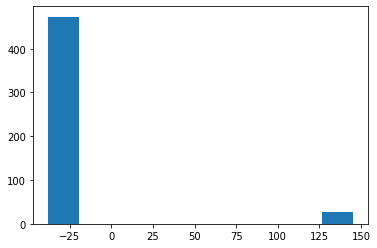

In [25]:
plt.hist(dirty_data['customer_lat'])
#Some outliers for values of Latitude on the extreme right tail

In [26]:
#Check for the range of possible values of customer_lat
dirty_data['customer_long'].describe()

count    500.000000
mean     135.096047
std       41.352818
min      -37.826438
25%      144.948637
50%      144.962340
75%      144.977532
max      145.020920
Name: customer_long, dtype: float64

Similarly, Coordinates like Longitude for locations in Melbourne cannot have values like -37. Let's have some graphical visualization to investigate this issue.

(array([ 27.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 473.]),
 array([-37.826438  , -19.54170221,  -1.25696642,  17.02776937,
         35.31250516,  53.59724095,  71.88197674,  90.16671253,
        108.45144832, 126.73618411, 145.0209199 ]),
 <a list of 10 Patch objects>)

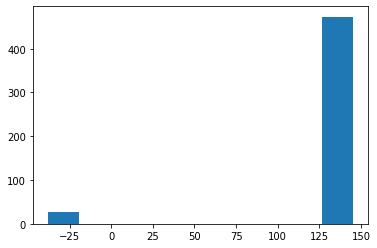

In [27]:
plt.hist(dirty_data['customer_long'])
##Some outliers for values of Longitude on the extreme left tail

The maximum observation for latitude is 145.003239 while the minimum observation for longtitude is -37.826438 which are not within the possible range of values in this dataset. The histograms also confirms this. We need to investigate further

In [28]:
print(len(dirty_data[dirty_data['customer_lat']>-37]))
print(len(dirty_data[dirty_data['customer_long']<144]))

27
27


In [29]:
dirty_data[dirty_data['customer_lat']>-37]

,order_id,customer_id,date,nearest_warehouse,shopping_cart,order_price,delivery_charges,customer_lat,customer_long,coupon_discount,order_total,season,is_expedited_delivery,distance_to_nearest_warehouse,latest_customer_review,is_happy_customer
81,ORD062042,ID0844481986,2019-12-27,Thompson,"[('Toshika 750', 1), ('Lucent 330S', 2), ('Can...",9820,73.61,144.948592,-37.820608,5,9402.61,Summer,False,0.8934,it works good! i love the graphics it meets my...,True
85,ORD413801,ID0638051739,2019-11-02,Nickolson,"[('Universe Note', 2), ('Olivia x460', 1), ('T...",13305,72.59,144.966224,-37.818054,10,12047.09,Spring,False,0.2987,great !!! i was surprised at this phone. i did...,True
98,ORD378140,ID0846591611,2019-07-14,Nickolson,"[('iStream', 2), ('Thunder line', 2), ('Olivia...",5885,59.71,144.969508,-37.822078,0,5944.71,Winter,True,0.3877,battery is fried. drains in my pocket. phone i...,False
125,ORD044550,ID2187980390,2019-05-20,Nickolson,"[('iAssist Line', 1), ('Olivia x460', 1)]",3450,64.74,144.965643,-37.813484,25,2652.24,Autumn,False,0.6647,best value phone on the market pros: price/per...,True
138,ORD321302,ID0440051991,2019-02-24,Bakers,"[('Alcon 10', 2), ('Universe Note', 1), ('iAss...",23575,66.41,144.994873,-37.823494,25,17747.66,Summer,False,1.5028,one star it won't charge so i sent it back,False
147,ORD143618,ID0844495918,2019-04-27,Thompson,"[('Thunder line', 1), ('pearTV', 2), ('Lucent ...",17260,66.58,144.952693,-37.819539,15,14737.58,Autumn,False,0.9104,"it's fun to use, and makes my life easier in s...",True
198,ORD370299,ID6167417916,2019-07-20,Thompson,"[('Candle Inferno', 2), ('Alcon 10', 2), ('Uni...",25660,77.78,144.954195,-37.816779,15,21888.78,Winter,True,0.7757,overall a very nice phone with an excellent ca...,True
222,ORD150117,ID0501019005,2019-05-27,Nickolson,"[('Thunder line', 2), ('Lucent 330S', 2), ('iS...",19590,66.93,144.973113,-37.804922,10,17697.93,Autumn,False,1.5539,five stars very good,True
241,ORD319939,ID0311908594,2019-10-13,Thompson,"[('Thunder line', 1), ('Universe Note', 1)]",5630,83.69,144.962773,-37.803030,5,5432.19,Spring,False,1.7493,perfection! this was an amazing purchase. the ...,True
255,ORD456224,ID0363973195,2019-07-07,Bakers,"[('Toshika 750', 2), ('iAssist Line', 1), ('Ca...",23915,51.51,144.989049,-37.803247,25,17987.76,Winter,False,0.9274,don’t buy! it is the worst phone i’ve ever see...,False


These 27 rows have their `customer_lat` and `customer_long` mixed up. We need to swap them. We also need to update `maybe_clear_data`

In [30]:
tmp=dirty_data[dirty_data['customer_lat']>-37]

#Update maybe_clean_data
maybe_clean_data=maybe_clean_data.drop(tmp.index,axis=0)

In [31]:
#Swap the longitude and latitude values
dirty_data.loc[list(tmp.index),'customer_lat']=tmp['customer_long'].values
dirty_data.loc[list(tmp.index),'customer_long']=tmp['customer_lat'].values

In [32]:
dirty_data['customer_lat'].describe()

count    500.000000
mean     -37.812299
std        0.007628
min      -37.833482
25%      -37.818454
50%      -37.812894
75%      -37.805755
max      -37.793099
Name: customer_lat, dtype: float64

In [33]:
dirty_data['customer_long'].describe()

count    500.000000
mean     144.966071
std        0.021578
min      144.916746
25%      144.951895
50%      144.963380
75%      144.978847
max      145.020920
Name: customer_long, dtype: float64

All the values of `customer_lat` and `customer_long` are fixed to be within reasonable ranges of values now.

### Examine `season`

In [34]:
dirty_data['season'].unique()

array(['Winter', 'Spring', 'Autumn', 'Summer', 'autumn', 'spring',
       'summer', 'winter'], dtype=object)

There are inconsistencies in formatting of values of `season`. I will fix this by capitalizing the values, to ensure the consistency.

In [35]:
#Get the list of all the lowercase season
lowercase_season=[i for i in dirty_data['season'].unique().tolist() if i[0].isupper()==False]
lowercase_season

['autumn', 'spring', 'summer', 'winter']

In [36]:
wrong_season=dirty_data[dirty_data['season'].isin(lowercase_season)]

In [37]:
#Update maybe_clean_data
maybe_clean_data=maybe_clean_data.drop(wrong_season.index,axis=0)

In [38]:
#Make the changes to lowercase, by capitalizing on the values of season
dirty_data['season']=dirty_data['season'].apply(lambda x: x.capitalize())

In [39]:
dirty_data['season'].unique()

array(['Winter', 'Spring', 'Autumn', 'Summer'], dtype=object)

There are no more inconsistencies, regarding the format of values of `season`.

Next, according to business rules, the seasons are defined as followed:
- Spring: September, October, November
- Summer: December, January, February
- Autumn: March, April, May
- Winter: June, July, August

We cross-check between `season` and `date` to see if there are any discrepancies.

In [40]:
#Define a function to return the corresponding season for each month
def dateseason(x):
    if x in [9,10,11]:
        return ('Spring')
    if x in [12,1,2]:
        return ('Summer')
    if x in [3,4,5]:
        return ('Autumn')
    else:
        return ('Winter')
    
#Create a new column that return the season, according to the values of date
dirty_data['date_season']=dirty_data['date'].apply(lambda x: dateseason(x.month))

In [41]:
#Check if there are any differences in values between season and date_season
wrong_season_2=dirty_data.loc[dirty_data['season']!=dirty_data['date_season']]
wrong_season_2

,order_id,customer_id,date,nearest_warehouse,shopping_cart,order_price,delivery_charges,customer_lat,customer_long,coupon_discount,order_total,season,is_expedited_delivery,distance_to_nearest_warehouse,latest_customer_review,is_happy_customer,date_season
77,ORD340626,ID0441031804,2019-06-28,Thompson,"[('Universe Note', 1), ('Candle Inferno', 2), ...",6760,65.89,-37.813355,144.937727,0,6825.89,Autumn,False,0.8251,works very well. easy to carry around & connec...,True,Winter
83,ORD452195,ID0611991912,2019-04-14,Thompson,"[('Lucent 330S', 1), ('iAssist Line', 1), ('Ol...",23805,65.39,-37.803331,144.955505,15,20299.64,Spring,True,1.2775,signals problem this phone is not working prop...,False,Autumn
103,ORD119848,ID3204395237,2019-08-10,Thompson,"[('Olivia x460', 1), ('Toshika 750', 1)]",5545,49.01,-37.806940,144.948877,0,5594.01,Autumn,False,0.6577,one star worst phone,False,Winter
131,ORD076123,ID0844475923,2019-06-11,Thompson,"[('Alcon 10', 1), ('Olivia x460', 1), ('Candle...",13495,78.33,-37.822516,144.947704,15,11549.08,Summer,True,1.0971,works as expected the camera isn’t great,True,Winter
166,ORD117244,ID0775945816,2019-09-20,Nickolson,"[('iAssist Line', 1), ('pearTV', 1)]",8535,82.32,-37.806690,144.962453,25,6483.57,Summer,False,1.4649,phone works great and looks brand new phone wo...,True,Spring
186,ORD154768,ID0571731122,2019-11-24,Thompson,"[('Thunder line', 1), ('Olivia x460', 2)]",4630,104.91,-37.824531,144.943450,0,4734.91,Summer,True,1.3578,awesome awesome. all i have to say,True,Spring
192,ORD118633,ID0145249642,2019-05-06,Nickolson,"[('Lucent 330S', 1), ('pearTV', 1), ('Alcon 10...",27665,65.66,-37.815787,144.960153,15,23580.91,Summer,False,0.8836,great buy. would buy again. phone came earlier...,True,Autumn
195,ORD260307,ID0781109163,2019-01-13,Bakers,"[('pearTV', 1), ('Universe Note', 2), ('Toshik...",21850,67.77,-37.814526,145.015511,15,18640.27,Winter,False,1.8533,don't buy any products from this seller. digic...,False,Summer
230,ORD225678,ID0664378468,2019-11-28,Nickolson,"[('iAssist Line', 2), ('Olivia x460', 2), ('Th...",11410,73.92,-37.820159,144.966941,5,10913.42,Summer,False,0.2881,problems with delivery but digico took care of...,True,Spring
314,ORD326799,ID2279007260,2019-03-31,Nickolson,"[('Olivia x460', 1), ('iStream', 2), ('Univers...",8425,64.55,-37.814985,144.960249,15,7225.80,Summer,False,0.9114,is cheap and beautiful easy to use is a good a...,True,Autumn


In [42]:
len(wrong_season_2)

20

There are 20 rows with wrong values of `season`. Change them with the values of `date_season`.

In [43]:
dirty_data.loc[list(wrong_season_2.index),'season']=wrong_season_2['date_season'].values

In [44]:
dirty_data.loc[dirty_data["season"]!=dirty_data["date_season"]]  #No more inconsistent values of season

,order_id,customer_id,date,nearest_warehouse,shopping_cart,order_price,delivery_charges,customer_lat,customer_long,coupon_discount,order_total,season,is_expedited_delivery,distance_to_nearest_warehouse,latest_customer_review,is_happy_customer,date_season


In [45]:
dirty_data=dirty_data.drop('date_season',axis=1)

### Examine `is_expedited_delivery`

In [46]:
dirty_data['is_expedited_delivery'].isnull().sum()  #No missing values in is_expedited_delivery

0

In [47]:
dirty_data['is_expedited_delivery'].unique()  #Only 2 possible values False or True, so correct format

array([False,  True])

In [48]:
dirty_data['is_expedited_delivery'].dtype   #Correct datatype of boolean values True and False

dtype('bool')

### Examine `distance_to_nearest_warehouse`

In [49]:
warehouse

,names,lat,lon
0,Nickolson,-37.818595,144.969551
1,Thompson,-37.812673,144.947069
2,Bakers,-37.809996,144.995232


In [50]:
#Assign variables for the coordinates of warehouses
Nickolson_lat=warehouse[warehouse["names"]=="Nickolson"]["lat"]
Nickolson_lon=warehouse[warehouse["names"]=="Nickolson"]["lon"]
Thompson_lat=warehouse[warehouse["names"]=="Thompson"]["lat"]
Thompson_lon=warehouse[warehouse["names"]=="Thompson"]["lon"]
Bakers_lat=warehouse[warehouse["names"]=="Bakers"]["lat"]
Bakers_lon=warehouse[warehouse["names"]=="Bakers"]["lon"]

In [51]:
#Define haversine() function to calculate distance between 2 GPS points
def haversine(lon1, lat1, lon2, lat2):
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dist_lon = lon2 - lon1 
    dist_lat = lat2 - lat1 
    a = sin(dist_lat/2)**2 + cos(lat1) * cos(lat2) * sin(dist_lon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6378 # Radius of earth in kilometers
    return c * r

In [52]:
#Define a function to return the distance for different warehouses
def warehouse_dist(x,y,z):
    if x=='Nickolson':
        return (round(haversine(Nickolson_lon,Nickolson_lat,y,z),4))
    elif x=='Thompson':
        return (round(haversine(Thompson_lon,Thompson_lat,y,z),4))
    else:
        return (round(haversine(Bakers_lon,Bakers_lat,y,z),4))
    
#Create a new column that returns the true distance_to_nearest_warehouse
dirty_data['true_distance']=dirty_data.apply(lambda x: warehouse_dist(x['nearest_warehouse'],x['customer_long'],
                                x['customer_lat']),axis=1)

In [53]:
#Check if there are any differences in values between distance_to_nearest_warehouse and true_distance
wrong_distance=dirty_data.loc[(round(dirty_data['distance_to_nearest_warehouse'],4))!=dirty_data['true_distance']]
wrong_distance

,order_id,customer_id,date,nearest_warehouse,shopping_cart,order_price,delivery_charges,customer_lat,customer_long,coupon_discount,order_total,season,is_expedited_delivery,distance_to_nearest_warehouse,latest_customer_review,is_happy_customer,true_distance
2,ORD147079,ID1224821948,2019-11-17,Nickolson,"[('Candle Inferno', 2), ('iAssist Line', 1), (...",14175,98.82,-37.812082,144.938374,5,13565.07,Spring,True,0.7675,most people will go with a bigger more sofisti...,True,2.8359
3,ORD006037,ID3240572176,2019-07-26,Thompson,"[('Thunder line', 1), ('Universe Note', 1), ('...",9085,68.83,-37.805653,144.930917,25,6882.58,Winter,False,0.9984,**positive review** good buy great price and m...,True,1.6213
6,ORD180076,ID0113535179,2019-04-02,Nickolson,"[('pearTV', 1), ('iAssist Line', 2)]",10760,48.80,-37.817811,144.964352,15,9194.80,Autumn,False,1.9948,i order the gold and didn’t get it color i ......,False,0.4654
10,ORD426931,ID1728565034,2019-10-05,Thompson,"[('Thunder line', 1), ('Toshika 750', 1), ('pe...",15260,102.36,-37.823133,144.951741,25,11547.36,Spring,True,0.8048,best android phone. this is the best android p...,True,1.2347
19,ORD369386,ID4754200365,2019-03-04,Thompson,"[('Alcon 10', 2), ('Universe Note', 1), ('Luce...",23960,82.02,-37.814986,144.927421,25,18052.02,Autumn,True,0.6790,excellent excelltnt,True,1.7470
35,ORD444759,ID0576874785,2019-07-23,Nickolson,"[('Candle Inferno', 1), ('pearTV', 2)]",13050,55.07,-37.824191,144.990068,0,13105.07,Winter,False,1.6441,one star a year later and it wont charge.,False,1.9086
42,ORD064715,ID5290706354,2019-07-22,Bakers,"[('pearTV', 1), ('Toshika 750', 1), ('Universe...",17530,79.49,-37.808154,144.976170,0,17609.49,Winter,True,1.2999,great product loved it,True,1.6889
45,ORD348139,ID0506049292,2019-07-26,Bakers,"[('iStream', 1), ('Thunder line', 2), ('Candle...",5370,66.77,-37.813024,144.935304,5,5168.27,Winter,False,1.0354,awesome its great. i love it.,True,5.2811
59,ORD024358,ID0577396699,2019-11-12,Nickolson,"[('iStream', 1), ('Lucent 330S', 2)]",2610,105.58,-37.821114,144.982478,15,2324.08,Spring,True,1.7577,love it very nice,True,1.1708
80,ORD281090,ID0778942366,2019-07-13,Bakers,"[('iAssist Line', 2), ('Lucent 330S', 1)]",5680,81.90,-37.814161,145.014446,0,5761.90,Winter,True,0.4220,best olivia unfortunately was a gift for my mo...,True,1.7522


In [54]:
len(wrong_distance)

47

There are 47 rows with wrong values of `distance_to_nearest_warehouse`. Change them with the values of `true_distance`. Also update `maybe_clean_data`

In [55]:
maybe_clean_data=maybe_clean_data.drop(wrong_distance.index,axis=0)

KeyError: '[  2  35  42  45 119 187 190 207 236 281 335 372 395 403 457 466 485 493] not found in axis'

It is indicated here that rows that have rows indices in `[  2  35  42  45 119 187 190 207 236 281 335 372 395 403 457 466 485 493]` are already deleted from `maybe_clean_data`. This is strange because it means those rows have already had their anomalies detected. After going back and checking, it seems that some of the corrections regarding `nearest_warehouse` might not be correct. For example, in row index 2, we fixed the `nearest_warehouse` to Nickolson and its `distance_to_nearest_warehouse` is not consistent with our calculated `true_distance`. This means 2 anomalies within 1 row which should not be the case **according to business rule**. Instead, if we fixed the `nearest_warehouse` to Thompson instead, we will then get the correct `distance_to_nearest_warehouse` and that means only 1 anomaly for this row. We fix `nearest_warehouse` for the other rows as well.

In [56]:
index_list=[2,35,42,45,119,187,190,207,236,281,335,372,395,403,457,466,485,493]
for i in index_list:
    if (warehouse_dist("Nickolson",wrong_distance[wrong_distance.index==i]["customer_long"],wrong_distance[wrong_distance.index==i]["customer_lat"])==wrong_distance[wrong_distance.index==i]["distance_to_nearest_warehouse"]).bool()==True:
        wrong_distance.loc[wrong_distance.index==i,"nearest_warehouse"]="Nickolson"
    elif (warehouse_dist("Thompson",wrong_distance[wrong_distance.index==i]["customer_long"],wrong_distance[wrong_distance.index==i]["customer_lat"])==wrong_distance[wrong_distance.index==i]["distance_to_nearest_warehouse"]).bool()==True:
        wrong_distance.loc[wrong_distance.index==i,"nearest_warehouse"]="Thompson"
    elif (warehouse_dist("Bakers",wrong_distance[wrong_distance.index==i]["customer_long"],wrong_distance[wrong_distance.index==i]["customer_lat"])==wrong_distance[wrong_distance.index==i]["distance_to_nearest_warehouse"]).bool()==True:
        wrong_distance.loc[wrong_distance.index==i,"nearest_warehouse"]="Bakers"
wrong_distance

,order_id,customer_id,date,nearest_warehouse,shopping_cart,order_price,delivery_charges,customer_lat,customer_long,coupon_discount,order_total,season,is_expedited_delivery,distance_to_nearest_warehouse,latest_customer_review,is_happy_customer,true_distance
2,ORD147079,ID1224821948,2019-11-17,Thompson,"[('Candle Inferno', 2), ('iAssist Line', 1), (...",14175,98.82,-37.812082,144.938374,5,13565.07,Spring,True,0.7675,most people will go with a bigger more sofisti...,True,2.8359
3,ORD006037,ID3240572176,2019-07-26,Thompson,"[('Thunder line', 1), ('Universe Note', 1), ('...",9085,68.83,-37.805653,144.930917,25,6882.58,Winter,False,0.9984,**positive review** good buy great price and m...,True,1.6213
6,ORD180076,ID0113535179,2019-04-02,Nickolson,"[('pearTV', 1), ('iAssist Line', 2)]",10760,48.80,-37.817811,144.964352,15,9194.80,Autumn,False,1.9948,i order the gold and didn’t get it color i ......,False,0.4654
10,ORD426931,ID1728565034,2019-10-05,Thompson,"[('Thunder line', 1), ('Toshika 750', 1), ('pe...",15260,102.36,-37.823133,144.951741,25,11547.36,Spring,True,0.8048,best android phone. this is the best android p...,True,1.2347
19,ORD369386,ID4754200365,2019-03-04,Thompson,"[('Alcon 10', 2), ('Universe Note', 1), ('Luce...",23960,82.02,-37.814986,144.927421,25,18052.02,Autumn,True,0.6790,excellent excelltnt,True,1.7470
35,ORD444759,ID0576874785,2019-07-23,Bakers,"[('Candle Inferno', 1), ('pearTV', 2)]",13050,55.07,-37.824191,144.990068,0,13105.07,Winter,False,1.6441,one star a year later and it wont charge.,False,1.9086
42,ORD064715,ID5290706354,2019-07-22,Nickolson,"[('pearTV', 1), ('Toshika 750', 1), ('Universe...",17530,79.49,-37.808154,144.976170,0,17609.49,Winter,True,1.2999,great product loved it,True,1.6889
45,ORD348139,ID0506049292,2019-07-26,Thompson,"[('iStream', 1), ('Thunder line', 2), ('Candle...",5370,66.77,-37.813024,144.935304,5,5168.27,Winter,False,1.0354,awesome its great. i love it.,True,5.2811
59,ORD024358,ID0577396699,2019-11-12,Nickolson,"[('iStream', 1), ('Lucent 330S', 2)]",2610,105.58,-37.821114,144.982478,15,2324.08,Spring,True,1.7577,love it very nice,True,1.1708
80,ORD281090,ID0778942366,2019-07-13,Bakers,"[('iAssist Line', 2), ('Lucent 330S', 1)]",5680,81.90,-37.814161,145.014446,0,5761.90,Winter,True,0.4220,best olivia unfortunately was a gift for my mo...,True,1.7522


So now rows with row indices in index_list no longer have `distance_to_nearest_warehouse` anomaly, but they have `nearest_warehouse` anomaly. Change the `nearest_warehouse` for these rows accordingly

In [57]:
dirty_data.loc[index_list,'nearest_warehouse']=wrong_distance.loc[index_list,'nearest_warehouse'].values

In [58]:
#Drop these rows from wrong_distance, leaving only the true wrong_distance anomalies
wrong_distance=wrong_distance.drop(index_list,axis=0)

#Update maybe_clean_data
maybe_clean_data=maybe_clean_data.drop(wrong_distance.index,axis=0)

In [59]:
#Replace the wrong values in distance_to_nearest_warehouse with the correct ones
dirty_data.loc[list(wrong_distance.index),'distance_to_nearest_warehouse']=wrong_distance['true_distance'].values

In [60]:
dirty_data=dirty_data.drop('true_distance',axis=1)

### Examine `latest_customer_review` and `is_happy_customer`

We need to check to see if the values between these 2 columns are consistent with one another.

In [61]:
sia=SentimentIntensityAnalyzer()

In [62]:
#Define a function to return the corresponding sentiment for each review
def cust_sentiment(x):
    sen_dict=sia.polarity_scores(x)
    if (sen_dict['compound']>=0.05) | (x=='None'):
        return True
    else:
        return False

#Create a new column that returns the boolean value of sentiment of customer based on the values of latest_customer_review
dirty_data['sentiment']=dirty_data['latest_customer_review'].apply(lambda x: cust_sentiment(x))

In [63]:
#Check if there are any differences in values between is_happy_customer and sentiment
wrong_sentiment=dirty_data.loc[dirty_data['is_happy_customer']!=dirty_data['sentiment']]
wrong_sentiment

,order_id,customer_id,date,nearest_warehouse,shopping_cart,order_price,delivery_charges,customer_lat,customer_long,coupon_discount,order_total,season,is_expedited_delivery,distance_to_nearest_warehouse,latest_customer_review,is_happy_customer,sentiment
25,ORD312911,ID1449431395,2019-12-21,Nickolson,"[('Olivia x460', 1), ('Lucent 330S', 2), ('Thu...",25945,95.78,-37.812947,144.978317,25,19554.53,Summer,True,0.9947,great great phone... great battery... cant fin...,False,True
120,ORD408821,ID0140980391,2019-11-21,Nickolson,"[('Alcon 10', 2), ('Lucent 330S', 2)]",20360,113.16,-37.798787,144.968896,10,18437.16,Spring,True,2.2058,five stars phone came in good condition. works...,False,True
170,ORD409168,ID0163648002,2019-10-23,Nickolson,"[('Candle Inferno', 2), ('Thunder line', 2), (...",9670,88.13,-37.820214,144.960158,25,7340.63,Spring,True,0.8454,márcame 415 8714917 el teléfono no sirve no se...,True,False
180,ORD056186,ID6197209825,2019-10-16,Thompson,"[('iStream', 2), ('Alcon 10', 1), ('Candle Inf...",12335,79.99,-37.817864,144.932218,0,12414.99,Spring,False,1.4281,check if 1st party or 2nd or 3rd party before ...,False,True
181,ORD482740,ID0092130447,2019-10-24,Thompson,"[('Alcon 10', 1), ('pearTV', 1), ('iStream', 2)]",15560,71.38,-37.812668,144.943074,5,14853.38,Spring,False,0.3513,"i love it and it works great, the only issue i...",False,True
189,ORD162042,ID1838361787,2019-06-15,Nickolson,"[('Thunder line', 2), ('iStream', 1), ('Toshik...",15610,51.34,-37.811587,144.964810,10,14100.34,Winter,False,0.8845,not unlocked not unlocked!,True,False
199,ORD390577,ID0373635381,2019-10-20,Thompson,"[('Candle Inferno', 2), ('Thunder line', 2), (...",18430,89.34,-37.822849,144.954628,10,16676.34,Spring,True,1.3134,wasted $30. esn of the phone does not match th...,True,False
221,ORD412791,ID0576868765,2019-01-22,Bakers,"[('Toshika 750', 2), ('Olivia x460', 2), ('iAs...",15690,65.86,-37.823822,144.990225,15,13402.36,Summer,False,1.6008,la bateria no sirve lo voy a regresar porque l...,True,False
244,ORD041325,ID0244222121,2019-10-04,Nickolson,"[('Toshika 750', 1), ('Alcon 10', 1)]",13270,110.19,-37.800399,144.970461,0,13380.19,Spring,True,2.0271,nice phones great phones. battery last forever...,False,True
267,ORD147840,ID0233275028,2019-10-24,Bakers,"[('pearTV', 2), ('Thunder line', 2)]",16980,94.55,-37.800234,144.977063,15,14527.55,Spring,True,1.9325,not what i ordered!!! the phone was not new fr...,True,False


In [64]:
len(wrong_sentiment)

27

There are 27 rows of `is_happy_customer` that are not correct. Change them with values in `sentiment`. Also update `maybe_clean_data`

In [65]:
#Update maybe_clean_data
maybe_clean_data=maybe_clean_data.drop(wrong_sentiment.index,axis=0)

#Replace with correct sentiment
dirty_data.loc[list(wrong_sentiment.index),'is_happy_customer']=wrong_sentiment['sentiment'].values

In [66]:
dirty_data.loc[dirty_data["is_happy_customer"]!=dirty_data["sentiment"]]

,order_id,customer_id,date,nearest_warehouse,shopping_cart,order_price,delivery_charges,customer_lat,customer_long,coupon_discount,order_total,season,is_expedited_delivery,distance_to_nearest_warehouse,latest_customer_review,is_happy_customer,sentiment


In [67]:
dirty_data=dirty_data.drop('sentiment',axis=1)

### Examine `shopping_cart`, `order_price` and `order_total`

For these 3 attributes/columns, we need to deal with them together. This is where we make use of `maybe_clean_data`

There are only 10 branded items, so we need to check if there are only 10 unique items value in `shopping_cart`. We do this by creating a new column `shopping_cart_eval` that converts strings in `shopping_cart` into lists

In [68]:
dirty_data['shopping_cart_eval']=dirty_data['shopping_cart'].apply(lambda x: eval(x))

In [69]:
item_list=[]
for i in dirty_data['shopping_cart_eval']:
    for j in i:
        #Name of the item is always the first item in the sublist
        if j[0] not in item_list:
            item_list.append(j[0])
item_list

['Universe Note',
 'Lucent 330S',
 'Candle Inferno',
 'Alcon 10',
 'Olivia x460',
 'iAssist Line',
 'iStream',
 'Toshika 750',
 'Thunder line',
 'pearTV']

In [70]:
len(item_list)

10

There are indeed only 10 unique items sold in `shopping_cart`. We will use `wrong_sentiment` dataframe to find out the price of each item since this dataframe contains rows that have correct information for everything except `is_happy_customer`

In [71]:
wrong_sentiment['shopping_cart_eval']=wrong_sentiment['shopping_cart'].apply(lambda x: eval(x))

In [72]:
outside_list=[]
for i in wrong_sentiment['shopping_cart_eval'].head(10): 
    #Need 10 equations to solve a simultaneous linear equation problem of 10 variables
    #Create a list to be populated with the quantity of each item later
    inside_list=[0]*10
    for j in i:
        if j[0]==item_list[0]:
            inside_list[0]=j[1]
        elif j[0]==item_list[1]:
            inside_list[1]=j[1]
        elif j[0]==item_list[2]:
            inside_list[2]=j[1]
        elif j[0]==item_list[3]:
            inside_list[3]=j[1]  
        elif j[0]==item_list[4]:
            inside_list[4]=j[1]
        elif j[0]==item_list[5]:
            inside_list[5]=j[1]
        elif j[0]==item_list[6]:
            inside_list[6]=j[1]
        elif j[0]==item_list[7]:
            inside_list[7]=j[1]
        elif j[0]==item_list[8]:
            inside_list[8]=j[1]
        elif j[0]==item_list[9]:
            inside_list[9]=j[1]
    outside_list.append(inside_list)

In [73]:
a=np.array(outside_list)
b=np.array(wrong_sentiment['order_price'].head(10))

#Solve a simultaneous linear equation problem involving 10 variables
price_list=np.linalg.solve(a,b)
price_list

array([3450., 1230.,  430., 8950., 1225., 2225.,  150., 4320., 2180.,
       6310.])

These are the prices of the 10 items. With `maybe_clean_data` until now, we are guaranteed that there can be only 1 anomaly among these 3 columns `shopping_cart`, `order_price` and `order_total` per row. Since we can only have 1 anomaly per row, we have 2 scenarios regarding these 3 variables. For rows that have the results of `order_price` and `order_total` being consistent with each other, the anomaly must be in `shopping_cart`(also only 1 item can be incorrect). If the results are not consistent, then either `order_price` or `order_total` is wrong, and we can use the information in `shopping_cart` to make amends. 

In [74]:
maybe_clean_data["shopping_cart_eval"]=maybe_clean_data["shopping_cart"].apply(lambda x: eval(x))  

In [75]:
#Create a function to calculate the order_total based on order_price, delivery_charges and coupon_discount
def get_total(x,y,z):
    return (x*(100-y)/100+z)

#Create a new column correct_total that is based on order_price, delivery charges and coupon_discount
maybe_clean_data["correct_total"]=maybe_clean_data.apply(lambda x: get_total(x["order_price"],
                                            x["coupon_discount"],x["delivery_charges"]),axis=1)

In [76]:
#Check for rows that have differences in value between order_total and correct_total
wrong_total=maybe_clean_data[maybe_clean_data["order_total"]!=maybe_clean_data["correct_total"]]
len(wrong_total)

54

These 54 rows in `wrong_total` have either `order_price` or `order_total` wrong, but `shopping_cart` values are correct. We will make calculation based on `shopping_cart` for these 54 rows 

In [77]:
#We create a new empty column called true_order_price so we can fill in the correct order_price calculation later. 
wrong_total["true_order_price"]=np.nan

In [78]:
wrong_total

,order_id,customer_id,date,nearest_warehouse,shopping_cart,order_price,delivery_charges,customer_lat,customer_long,coupon_discount,order_total,season,is_expedited_delivery,distance_to_nearest_warehouse,latest_customer_review,is_happy_customer,shopping_cart_eval,correct_total,true_order_price
14,ORD304674,ID1496246612,2019-03-06,Nickolson,"[('Universe Note', 1), ('Toshika 750', 1), ('p...",16530,80.56,-37.825849,144.979272,15,16557.25,Autumn,True,1.1759,we love it (it was a gift for my wife) it's be...,True,"[(Universe Note, 1), (Toshika 750, 1), (pearTV...",14131.06,NaN
28,ORD287146,ID1492410200,2019-11-06,Nickolson,"[('Toshika 750', 2), ('Thunder line', 2)]",11280,83.12,-37.805850,144.963106,0,13083.12,Spring,False,1.5278,"great phone,! i'm in love with this phone! it ...",True,"[(Toshika 750, 2), (Thunder line, 2)]",11363.12,NaN
46,ORD086319,ID0373644692,2019-03-16,Thompson,"[('Thunder line', 2), ('pearTV', 1), ('Candle ...",11530,70.84,-37.808185,144.921075,10,2979.03,Autumn,True,2.3400,horrible horrible phone horrible horrible phon...,False,"[(Thunder line, 2), (pearTV, 1), (Candle Infer...",10447.84,NaN
47,ORD376132,ID0282852559,2019-10-24,Bakers,"[('Thunder line', 1), ('iAssist Line', 1), ('i...",2610,83.96,-37.796493,145.008331,15,4686.71,Spring,False,1.8938,great phone cheap price i like the phone overa...,True,"[(Thunder line, 1), (iAssist Line, 1), (iStrea...",2302.46,NaN
57,ORD175040,ID0030240836,2019-12-15,Thompson,"[('Olivia x460', 1), ('Thunder line', 2), ('iS...",5735,79.68,-37.801308,144.957545,10,2289.49,Summer,False,1.5651,ok it's very hot,True,"[(Olivia x460, 1), (Thunder line, 2), (iStream...",5241.18,NaN
58,ORD488671,ID1715989157,2019-11-10,Nickolson,"[('iAssist Line', 1), ('pearTV', 2)]",14845,70.94,-37.818734,144.967859,15,16194.99,Spring,False,0.1496,phone is unlocked & perfect for the price phon...,True,"[(iAssist Line, 1), (pearTV, 2)]",12689.19,NaN
62,ORD028474,ID0588198718,2019-06-21,Nickolson,"[('Lucent 330S', 2), ('pearTV', 1)]",10360,76.96,-37.812154,144.973932,15,7531.46,Winter,True,0.8140,new phone. works great! very satisfied!,True,"[(Lucent 330S, 2), (pearTV, 1)]",8882.96,NaN
63,ORD468898,ID0054552820,2019-08-28,Nickolson,"[('iAssist Line', 2), ('iStream', 1), ('Alcon ...",13550,52.36,-37.820590,144.983825,5,9642.03,Winter,False,1.2747,one star the product failed not recommend this...,False,"[(iAssist Line, 2), (iStream, 1), (Alcon 10, 1)]",12924.86,NaN
67,ORD234910,ID6197211467,2019-12-31,Thompson,"[('Universe Note', 2), ('iStream', 2), ('Alcon...",16150,95.63,-37.812958,144.933682,15,13355.70,Summer,True,1.1777,"best phone for the price, even better than the...",True,"[(Universe Note, 2), (iStream, 2), (Alcon 10, 1)]",13823.13,NaN
69,ORD381318,ID1982309205,2019-11-17,Bakers,"[('iStream', 2), ('Olivia x460', 2), ('Toshika...",33740,103.46,-37.800964,144.990979,5,6819.96,Spring,True,1.0728,"😍 bought as xmas gift for my wife, she likes it",True,"[(iStream, 2), (Olivia x460, 2), (Toshika 750,...",32156.46,NaN


In [79]:
row_no=0
wt_index=wrong_total.index
#For each row, we calculate the total price by summing up the product of price of each item and its quantity
for i in wrong_total["shopping_cart_eval"]:
    price=0
    for j in i:
        if j[0]==item_list[0]:
            price+=price_list[0]*j[1]
        elif j[0]==item_list[1]:
            price+=price_list[1]*j[1]
        elif j[0]==item_list[2]:
            price+=price_list[2]*j[1]
        elif j[0]==item_list[3]:
            price+=price_list[3]*j[1]
        elif j[0]==item_list[4]:
            price+=price_list[4]*j[1]
        elif j[0]==item_list[5]:
            price+=price_list[5]*j[1]
        elif j[0]==item_list[6]:
            price+=price_list[6]*j[1]
        elif j[0]==item_list[7]:
            price+=price_list[7]*j[1]
        elif j[0]==item_list[8]:
            price+=price_list[8]*j[1]
        elif j[0]==item_list[9]:
            price+=price_list[9]*j[1]
    wrong_total.loc[wt_index[row_no],"true_order_price"]=price
    row_no+=1

In [80]:
wrong_total

,order_id,customer_id,date,nearest_warehouse,shopping_cart,order_price,delivery_charges,customer_lat,customer_long,coupon_discount,order_total,season,is_expedited_delivery,distance_to_nearest_warehouse,latest_customer_review,is_happy_customer,shopping_cart_eval,correct_total,true_order_price
14,ORD304674,ID1496246612,2019-03-06,Nickolson,"[('Universe Note', 1), ('Toshika 750', 1), ('p...",16530,80.56,-37.825849,144.979272,15,16557.25,Autumn,True,1.1759,we love it (it was a gift for my wife) it's be...,True,"[(Universe Note, 1), (Toshika 750, 1), (pearTV...",14131.06,16530.0
28,ORD287146,ID1492410200,2019-11-06,Nickolson,"[('Toshika 750', 2), ('Thunder line', 2)]",11280,83.12,-37.805850,144.963106,0,13083.12,Spring,False,1.5278,"great phone,! i'm in love with this phone! it ...",True,"[(Toshika 750, 2), (Thunder line, 2)]",11363.12,13000.0
46,ORD086319,ID0373644692,2019-03-16,Thompson,"[('Thunder line', 2), ('pearTV', 1), ('Candle ...",11530,70.84,-37.808185,144.921075,10,2979.03,Autumn,True,2.3400,horrible horrible phone horrible horrible phon...,False,"[(Thunder line, 2), (pearTV, 1), (Candle Infer...",10447.84,11530.0
47,ORD376132,ID0282852559,2019-10-24,Bakers,"[('Thunder line', 1), ('iAssist Line', 1), ('i...",2610,83.96,-37.796493,145.008331,15,4686.71,Spring,False,1.8938,great phone cheap price i like the phone overa...,True,"[(Thunder line, 1), (iAssist Line, 1), (iStrea...",2302.46,5415.0
57,ORD175040,ID0030240836,2019-12-15,Thompson,"[('Olivia x460', 1), ('Thunder line', 2), ('iS...",5735,79.68,-37.801308,144.957545,10,2289.49,Summer,False,1.5651,ok it's very hot,True,"[(Olivia x460, 1), (Thunder line, 2), (iStream...",5241.18,5735.0
58,ORD488671,ID1715989157,2019-11-10,Nickolson,"[('iAssist Line', 1), ('pearTV', 2)]",14845,70.94,-37.818734,144.967859,15,16194.99,Spring,False,0.1496,phone is unlocked & perfect for the price phon...,True,"[(iAssist Line, 1), (pearTV, 2)]",12689.19,14845.0
62,ORD028474,ID0588198718,2019-06-21,Nickolson,"[('Lucent 330S', 2), ('pearTV', 1)]",10360,76.96,-37.812154,144.973932,15,7531.46,Winter,True,0.8140,new phone. works great! very satisfied!,True,"[(Lucent 330S, 2), (pearTV, 1)]",8882.96,8770.0
63,ORD468898,ID0054552820,2019-08-28,Nickolson,"[('iAssist Line', 2), ('iStream', 1), ('Alcon ...",13550,52.36,-37.820590,144.983825,5,9642.03,Winter,False,1.2747,one star the product failed not recommend this...,False,"[(iAssist Line, 2), (iStream, 1), (Alcon 10, 1)]",12924.86,13550.0
67,ORD234910,ID6197211467,2019-12-31,Thompson,"[('Universe Note', 2), ('iStream', 2), ('Alcon...",16150,95.63,-37.812958,144.933682,15,13355.70,Summer,True,1.1777,"best phone for the price, even better than the...",True,"[(Universe Note, 2), (iStream, 2), (Alcon 10, 1)]",13823.13,16150.0
69,ORD381318,ID1982309205,2019-11-17,Bakers,"[('iStream', 2), ('Olivia x460', 2), ('Toshika...",33740,103.46,-37.800964,144.990979,5,6819.96,Spring,True,1.0728,"😍 bought as xmas gift for my wife, she likes it",True,"[(iStream, 2), (Olivia x460, 2), (Toshika 750,...",32156.46,7070.0


In [81]:
#see if there are any rows that have difference in values between order_price and true_order_price
wrong_order_price=wrong_total[round(wrong_total["order_price"],0)!=round(wrong_total["true_order_price"],0)]
len(wrong_order_price)

27

These 27 rows in `wrong_order_price` have the values of `order_price` incorrect. Replace them with the values in `true_order_price`

In [82]:
dirty_data.loc[list(wrong_order_price.index),'order_price']=wrong_order_price["true_order_price"].values
wrong_total_1=wrong_total.drop(list(wrong_order_price.index),axis=0)
len(wrong_total_1)

27

These 27 rows in the new updated `wrong_total_1` have the values of `order_price` correct, but wrong values of `order_total`. Since we also derived `correct_total` based on `order_price`, can simply replace `order_total` with `correct_total` for these 27 rows 

In [83]:
dirty_data.loc[list(wrong_total_1.index),'order_total']=wrong_total_1["correct_total"].values

Now we go back to `maybe_clean_data` and checks for rows that have the wrong values of `shopping_cart`

In [84]:
#Check for rows that have the same value between order_total and correct_total
wrong_shopping=maybe_clean_data[maybe_clean_data["order_total"]==maybe_clean_data["correct_total"]]
len(wrong_shopping)

289

So out of these 289 rows of `wrong_shopping`, there might be rows that contain the wrong values of `shopping_cart`. We can simply compute the `order_price` based on the values given in `shopping_cart` and then compare it with the actual value of `order_price`

In [85]:
#Create an empty column calculated_order_price to be filled in later
wrong_shopping["calculated_order_price"]=np.nan

In [86]:
ws_index=wrong_shopping.index
row_no=0
for i in wrong_shopping["shopping_cart_eval"]:
    price=0
    for j in i:
        if j[0]==item_list[0]:
            price+=price_list[0]*j[1]
        elif j[0]==item_list[1]:
            price+=price_list[1]*j[1]
        elif j[0]==item_list[2]:
            price+=price_list[2]*j[1]
        elif j[0]==item_list[3]:
            price+=price_list[3]*j[1]
        elif j[0]==item_list[4]:
            price+=price_list[4]*j[1]
        elif j[0]==item_list[5]:
            price+=price_list[5]*j[1]
        elif j[0]==item_list[6]:
            price+=price_list[6]*j[1]
        elif j[0]==item_list[7]:
            price+=price_list[7]*j[1]
        elif j[0]==item_list[8]:
            price+=price_list[8]*j[1]
        elif j[0]==item_list[9]:
            price+=price_list[9]*j[1]
    wrong_shopping.loc[ws_index[row_no],"calculated_order_price"]=price
    row_no+=1

In [87]:
#Check for rows that have difference in values between order_price and calculated_order_price
wrong_shopping_1=wrong_shopping[round(wrong_shopping["order_price"],0)!=round(wrong_shopping["calculated_order_price"],0)]
len(wrong_shopping_1)

27

These 27 rows of `wrong_shopping_1` have incorrect values of `shopping_cart`. There is only 1 item that is incorrectly inputted in each row. Consider a general case where we have 2 quations ax1+bx2=y1 and ax2+bx2=y2. We can see that x1-x2=(y1-y2)/a. This means that for each row, we take the difference between `order_price` and `calculated_order_price`. Then for each item in the cart, we divide that difference by the quantity of that item. If the sum of that result and the price of that item equal to the price of some other item, that means that other item should be the correct items that needs to be put in the `shopping_cart`

In [88]:
#First we make a dictionary of the item and price
price_item=dict(zip(item_list,price_list))
price_item

{'Universe Note': 3450.0,
 'Lucent 330S': 1230.0,
 'Candle Inferno': 430.0,
 'Alcon 10': 8950.0,
 'Olivia x460': 1225.0,
 'iAssist Line': 2225.0,
 'iStream': 150.0,
 'Toshika 750': 4320.0,
 'Thunder line': 2180.0,
 'pearTV': 6309.999999999999}

In [89]:
my_list=[]
row_no=0
for i in wrong_shopping_1["shopping_cart_eval"]:
    cart_list=[]
    print ("For shopping cart",i)
    p_diff=wrong_shopping_1.iloc[row_no]["order_price"]-wrong_shopping_1.iloc[row_no]["calculated_order_price"]
    for j in i:
        result=p_diff/(j[1])
        correct_p=result+price_item[j[0]]
        print ('correct price is',correct_p)
        pair=tuple([j[0],j[1]])
        cart_list.append(pair)
        for k in price_item.keys():
            if round(price_item[k],0)==round(correct_p,0):
                print ("Price of",k,"is",price_item[k])
                print (j[0],"should be changed to",k)
                correct_pair=tuple([k,j[1]])
                
                #Replace the wrong item with the correct item 
                del cart_list[-1]
                cart_list.append(correct_pair)
                
    print ("New cart list should be ",cart_list)
    my_list.append(cart_list)
    print ("\n")
    row_no+=1

For shopping cart [('Lucent 330S', 1), ('Candle Inferno', 1), ('Alcon 10', 2)]
correct price is 3025.0
correct price is 2225.0
Price of iAssist Line is 2225.0
Candle Inferno should be changed to iAssist Line
correct price is 9847.5
New cart list should be  [('Lucent 330S', 1), ('iAssist Line', 1), ('Alcon 10', 2)]


For shopping cart [('Universe Note', 1), ('Alcon 10', 1)]
correct price is -5070.0
correct price is 430.0
Price of Candle Inferno is 430.0
Alcon 10 should be changed to Candle Inferno
New cart list should be  [('Universe Note', 1), ('Candle Inferno', 1)]


For shopping cart [('Candle Inferno', 2), ('Thunder line', 1)]
correct price is 8950.0
Price of Alcon 10 is 8950.0
Candle Inferno should be changed to Alcon 10
correct price is 19220.0
New cart list should be  [('Alcon 10', 2), ('Thunder line', 1)]


For shopping cart [('Thunder line', 2), ('iStream', 2), ('Lucent 330S', 2), ('Alcon 10', 1)]
correct price is 3175.0
correct price is 1145.0
correct price is 2225.0
Price of 

In [90]:
my_list_df=pd.Series(my_list)

In [91]:
wrong_shopping_1["shopping_cart"] = my_list_df.values

In [92]:
#Change the wrong items in the cart with the correct ones
dirty_data.loc[list(wrong_shopping_1.index),'shopping_cart']=wrong_shopping_1["shopping_cart"].values

In [93]:
dirty_data=dirty_data.drop('shopping_cart_eval',axis=1)  

### The final clean dataset for `dirty_data` after a very thorough, extensive data wrangling process

In [94]:
dirty_data_cleansed=dirty_data
dirty_data_cleansed

,order_id,customer_id,date,nearest_warehouse,shopping_cart,order_price,delivery_charges,customer_lat,customer_long,coupon_discount,order_total,season,is_expedited_delivery,distance_to_nearest_warehouse,latest_customer_review,is_happy_customer
0,ORD377463,ID3743608254,2019-06-20,Thompson,"[('Universe Note', 2), ('Lucent 330S', 1), ('C...",17510.0,51.19,-37.822199,144.947623,5,16685.69,Winter,False,1.0615,just buy a $10 android phone instead what a pi...,False
1,ORD482178,ID4716795332,2019-11-20,Thompson,"[('Lucent 330S', 2), ('Olivia x460', 1), ('iAs...",8435.0,102.64,-37.819283,144.952701,10,7694.14,Spring,True,0.8870,i own the first and second generation thunder ...,True
2,ORD147079,ID1224821948,2019-11-17,Thompson,"[('Candle Inferno', 2), ('iAssist Line', 1), (...",14175.0,98.82,-37.812082,144.938374,5,13565.07,Spring,True,0.7675,most people will go with a bigger more sofisti...,True
3,ORD006037,ID3240572176,2019-07-26,Thompson,"[('Thunder line', 1), ('Universe Note', 1), ('...",9085.0,68.83,-37.805653,144.930917,25,6882.58,Winter,False,1.6213,**positive review** good buy great price and m...,True
4,ORD472716,ID0123087089,2019-04-28,Thompson,"[('iAssist Line', 1), ('Olivia x460', 1)]",3450.0,78.83,-37.814832,144.955431,25,2666.33,Autumn,True,0.7736,"mint condition phone is brand new, only minimu...",True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,ORD426280,ID0289607026,2019-10-31,Thompson,"[('Candle Inferno', 2), ('iAssist Line', 2), (...",22900.0,82.20,-37.813573,144.950238,10,20692.20,Spring,True,0.2962,i will never buy anything digico makes again!t...,False
496,ORD371871,ID1283617975,2019-07-20,Thompson,"[('iAssist Line', 2), ('Toshika 750', 2)]",13090.0,82.37,-37.799041,144.954157,10,11863.37,Winter,True,1.6405,beautiful phone that feels great in your hand ...,True
497,ORD412614,ID0541122887,2019-05-24,Bakers,"[(Candle Inferno, 1), (Olivia x460, 2)]",2880.0,70.40,-37.803874,145.015266,25,2230.40,Autumn,False,1.8892,good phone nice cellphone.,True
498,ORD458545,ID0233314919,2019-04-22,Nickolson,"[('Alcon 10', 1), ('Olivia x460', 2)]",11400.0,82.73,-37.803236,144.975000,0,11482.73,Autumn,True,1.7756,it’s okay there are some software bugs. beside...,True


## Outlier Data <a class="anchor" id="1.2"></a>

In this section, I will focus on using various graphical and non-graphical EDA methods to find out outliers in `Outlier_data` data file and remove them.

In [95]:
outlier_data=pd.read_csv('Outlier_data.csv')
outlier_data

,order_id,customer_id,date,nearest_warehouse,shopping_cart,order_price,delivery_charges,customer_lat,customer_long,coupon_discount,order_total,season,is_expedited_delivery,distance_to_nearest_warehouse,latest_customer_review,is_happy_customer
0,ORD241994,ID0060097369,2019-09-22,Thompson,"[('iAssist Line', 2), ('Lucent 330S', 2), ('Un...",13810,82.65,-37.810406,144.944922,5,13202.15,Spring,True,0.3152,"okay phone, died way too soon well, i thought ...",False
1,ORD414205,ID3222703108,2019-12-19,Thompson,"[('Toshika 750', 1), ('Candle Inferno', 1), ('...",8200,78.31,-37.803014,144.956079,15,7048.31,Summer,False,1.3357,five stars best olivia universe smartphone the...,True
2,ORD422050,ID4998966832,2019-07-04,Nickolson,"[('Toshika 750', 2), ('Thunder line', 2), ('Un...",28850,64.31,-37.809775,144.972401,15,24586.81,Winter,False,1.0133,it is so handsome cellular phone it is a wonde...,True
3,ORD474642,ID6167231019,2019-05-02,Thompson,"[('Alcon 10', 2), ('Candle Inferno', 1), ('Luc...",19560,65.05,-37.815255,144.952372,5,18647.05,Autumn,True,0.5478,glitched alot had issues from the jump,False
4,ORD007338,ID6167254915,2019-07-06,Nickolson,"[('Toshika 750', 1), ('Olivia x460', 2), ('Can...",10650,75.53,-37.818141,144.965112,10,9660.53,Winter,True,0.3936,five stars very nice phone,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,ORD108053,ID3098154904,2019-01-01,Thompson,"[('Olivia x460', 1), ('Lucent 330S', 2)]",3685,85.22,-37.822722,144.937247,10,3401.72,Summer,True,1.4132,worked for one day and then it died i would no...,False
496,ORD373744,ID4884445049,2019-06-29,Thompson,"[('Candle Inferno', 1), ('Olivia x460', 2), ('...",7200,70.19,-37.800848,144.934775,0,7270.19,Winter,False,1.7035,love love love this is so much better than the...,True
497,ORD035622,ID0054404478,2019-06-24,Thompson,"[('Olivia x460', 2), ('pearTV', 1)]",8760,66.98,-37.800108,144.949454,5,8388.98,Winter,False,1.4144,about the olivia s8 everything work perfectly ...,True
498,ORD455474,ID6167266620,2019-03-15,Nickolson,"[('Candle Inferno', 2), ('Lucent 330S', 2)]",3320,67.46,-37.809756,144.963796,15,2889.46,Autumn,False,1.1064,five stars i love my pixel!,True


According to business rules, outliers are to be found with respect to `delivery_charges` attributes only. We are also given that `delivery_charges` is calculated using a linear model on `season`, `distance_to_nearest_warehouse`, `is_expedited_delivery` and `is_happy_customer`. What we will do is running a regression model on these regressors to get the fitted values of `delivery_charges`, then we compute the residuals between the fitted values and the actual value of `delivery_charges`. Then, we have will some plots on the residuals (scatterplot, boxplot) and determine which are the outliers.

In [96]:
#We work with a copy of outlier_data, called outlier_data_1, which only contains the relavant regressors and the target
outlier_data_1=outlier_data.copy()
outlier_data_1=outlier_data_1[['delivery_charges','season','distance_to_nearest_warehouse',
                               'is_happy_customer','is_expedited_delivery']]
outlier_data_1

,delivery_charges,season,distance_to_nearest_warehouse,is_happy_customer,is_expedited_delivery
0,82.65,Spring,0.3152,False,True
1,78.31,Summer,1.3357,True,False
2,64.31,Winter,1.0133,True,False
3,65.05,Autumn,0.5478,False,True
4,75.53,Winter,0.3936,True,True
...,...,...,...,...,...
495,85.22,Summer,1.4132,False,True
496,70.19,Winter,1.7035,True,False
497,66.98,Winter,1.4144,True,False
498,67.46,Autumn,1.1064,True,False


Since `season` is a categorical variable, we need to convert it into dummy variables

In [97]:
outlier_data_1=pd.get_dummies(data=outlier_data_1)
outlier_data_1.head(5)

,delivery_charges,distance_to_nearest_warehouse,is_happy_customer,is_expedited_delivery,season_Autumn,season_Spring,season_Summer,season_Winter
0,82.65,0.3152,False,True,0,1,0,0
1,78.31,1.3357,True,False,0,0,1,0
2,64.31,1.0133,True,False,0,0,0,1
3,65.05,0.5478,False,True,1,0,0,0
4,75.53,0.3936,True,True,0,0,0,1


In [98]:
#Using all the other columns in outlier_data_1 to predict delivery_charges
lm_for_outlier=LinearRegression()
lm_for_outlier.fit(outlier_data_1[[x for x in outlier_data_1.columns if x!="delivery_charges"]],
                   outlier_data_1["delivery_charges"])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [99]:
#Get the fitted values of delivery_charges as a new column fitted_delivery_charges
outlier_data_1["fitted_delivery_charges"]=lm_for_outlier.predict(outlier_data_1.drop(["delivery_charges"],axis=1)) 

In [100]:
outlier_data_1.head(5)

,delivery_charges,distance_to_nearest_warehouse,is_happy_customer,is_expedited_delivery,season_Autumn,season_Spring,season_Summer,season_Winter,fitted_delivery_charges
0,82.65,0.3152,False,True,0,1,0,0,80.332562
1,78.31,1.3357,True,False,0,0,1,0,79.189910
2,64.31,1.0133,True,False,0,0,0,1,62.280129
3,65.05,0.5478,False,True,1,0,0,0,63.803915
4,75.53,0.3936,True,True,0,0,0,1,76.297310


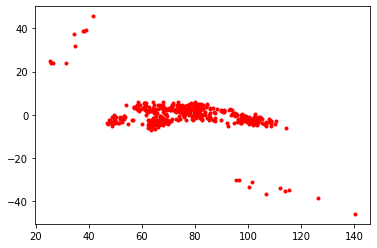

In [101]:
#Create a new column that returns the residuals between the fitted values and actual value of delivery_charges
outlier_data_1["residual"]=outlier_data_1["fitted_delivery_charges"]-outlier_data_1["delivery_charges"]

#Create a scatterplot of the actual delivery_charges vs the residual
plt.plot(outlier_data_1["delivery_charges"],outlier_data_1["residual"],'.r')

From the scatterplot, we can see clearly that most of the residuals concentrate around the 0 line (which means the fitted values and actual values are quite similar). However, some of the data points are on the upper left corner or lower right corner of the scatter plots, which are very far away from the 0 line. These are clearly outliers. We can inspect more by drawing a boxplot

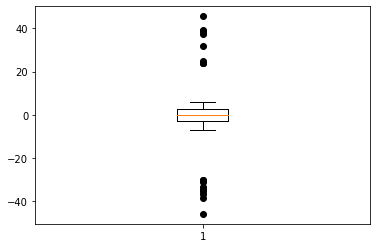

In [102]:
#Boxplot of residual
resid_bp=plt.boxplot(outlier_data_1["residual"],sym="k")

The boxplot also confirms the findings, as the median line is around 0, the height of the box as well as the distance between the fences are quite small, indicating a large concentration of datapoints around 0. However, there are some clear outliers far above the upper fence as well as far below the lower fence. We identify them and remove them

In [103]:
#Get the values of the lower fence and upper fence
bp_fences=[i.get_ydata()[1] for i in resid_bp['whiskers']]
bp_fences

[-6.975072045273912, 6.104020826752979]

In [104]:
#Outliers that are below the lower fence
outlier_1=outlier_data_1[outlier_data_1["residual"]<bp_fences[0]]

#Outliers that are above the upper fence
outlier_2=outlier_data_1[outlier_data_1["residual"]>bp_fences[1]]

In [105]:
#Remove these outliers from the original data
outlier_data=outlier_data.drop(outlier_1.index,axis=0)
outlier_data=outlier_data.drop(outlier_2.index,axis=0)

### Final cleansed version of `Outlier_data`, after getting rid of outliers

In [106]:
outlier_data_cleansed=outlier_data
outlier_data_cleansed

,order_id,customer_id,date,nearest_warehouse,shopping_cart,order_price,delivery_charges,customer_lat,customer_long,coupon_discount,order_total,season,is_expedited_delivery,distance_to_nearest_warehouse,latest_customer_review,is_happy_customer
0,ORD241994,ID0060097369,2019-09-22,Thompson,"[('iAssist Line', 2), ('Lucent 330S', 2), ('Un...",13810,82.65,-37.810406,144.944922,5,13202.15,Spring,True,0.3152,"okay phone, died way too soon well, i thought ...",False
1,ORD414205,ID3222703108,2019-12-19,Thompson,"[('Toshika 750', 1), ('Candle Inferno', 1), ('...",8200,78.31,-37.803014,144.956079,15,7048.31,Summer,False,1.3357,five stars best olivia universe smartphone the...,True
2,ORD422050,ID4998966832,2019-07-04,Nickolson,"[('Toshika 750', 2), ('Thunder line', 2), ('Un...",28850,64.31,-37.809775,144.972401,15,24586.81,Winter,False,1.0133,it is so handsome cellular phone it is a wonde...,True
3,ORD474642,ID6167231019,2019-05-02,Thompson,"[('Alcon 10', 2), ('Candle Inferno', 1), ('Luc...",19560,65.05,-37.815255,144.952372,5,18647.05,Autumn,True,0.5478,glitched alot had issues from the jump,False
4,ORD007338,ID6167254915,2019-07-06,Nickolson,"[('Toshika 750', 1), ('Olivia x460', 2), ('Can...",10650,75.53,-37.818141,144.965112,10,9660.53,Winter,True,0.3936,five stars very nice phone,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,ORD108053,ID3098154904,2019-01-01,Thompson,"[('Olivia x460', 1), ('Lucent 330S', 2)]",3685,85.22,-37.822722,144.937247,10,3401.72,Summer,True,1.4132,worked for one day and then it died i would no...,False
496,ORD373744,ID4884445049,2019-06-29,Thompson,"[('Candle Inferno', 1), ('Olivia x460', 2), ('...",7200,70.19,-37.800848,144.934775,0,7270.19,Winter,False,1.7035,love love love this is so much better than the...,True
497,ORD035622,ID0054404478,2019-06-24,Thompson,"[('Olivia x460', 2), ('pearTV', 1)]",8760,66.98,-37.800108,144.949454,5,8388.98,Winter,False,1.4144,about the olivia s8 everything work perfectly ...,True
498,ORD455474,ID6167266620,2019-03-15,Nickolson,"[('Candle Inferno', 2), ('Lucent 330S', 2)]",3320,67.46,-37.809756,144.963796,15,2889.46,Autumn,False,1.1064,five stars i love my pixel!,True


## Missing Data <a class="anchor" id="1.3"></a>

In this section, I will impute the missing values for some of the attributes in `Missing_data` dataset, based on the given business rules

In [107]:
missing_data=pd.read_csv('Missing_data.csv')
missing_data.head(5)

,order_id,customer_id,date,nearest_warehouse,shopping_cart,order_price,delivery_charges,customer_lat,customer_long,coupon_discount,order_total,season,is_expedited_delivery,distance_to_nearest_warehouse,latest_customer_review,is_happy_customer
0,ORD055086,ID0709951238,2019-04-21,Thompson,"[('Universe Note', 2), ('Olivia x460', 1), ('p...",NaN,80.21,-37.811435,144.935431,0,NaN,Autumn,True,1.0327,five stars good buy,1.0
1,ORD457366,ID6167489459,2019-02-15,NaN,"[('Candle Inferno', 2), ('iAssist Line', 2), (...",7770.0,73.26,-37.814880,144.960820,15,6677.76,Summer,False,NaN,five stars it was great,1.0
2,ORD030511,ID2187972533,2019-01-31,Nickolson,"[('Alcon 10', 1), ('iAssist Line', 1)]",11175.0,61.14,-37.809569,144.963802,15,9559.89,Summer,False,1.1248,shattered on arrival both arrived shattered. p...,0.0
3,ORD479424,ID0250480672,2019-04-13,Bakers,"[('Candle Inferno', 1), ('pearTV', 2)]",13050.0,NaN,-37.809380,145.002554,5,12475.52,Autumn,True,0.6475,i like this phone but neds imprubments good ca...,1.0
4,ORD153282,ID3106293374,2019-04-21,NaN,"[('Lucent 330S', 1), ('Thunder line', 2), ('To...",14230.0,82.04,-37.806753,144.932573,10,12889.04,Autumn,True,NaN,five stars fan of the note phones from the beg...,1.0


In [108]:
missing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_id                       500 non-null    object 
 1   customer_id                    500 non-null    object 
 2   date                           500 non-null    object 
 3   nearest_warehouse              445 non-null    object 
 4   shopping_cart                  500 non-null    object 
 5   order_price                    485 non-null    float64
 6   delivery_charges               460 non-null    float64
 7   customer_lat                   500 non-null    float64
 8   customer_long                  500 non-null    float64
 9   coupon_discount                500 non-null    int64  
 10  order_total                    485 non-null    float64
 11  season                         500 non-null    object 
 12  is_expedited_delivery          500 non-null    boo

There are some columns that have missing values, such as `nearest_warehouse`, `order_price`, `delivery_charges`, `order_total`, `distance_to_nearest_warehouse` and `is_happy_customer`. I will impute the missing values for these columns

### Examine `order_price`

In [109]:
missing_data['order_price'].isnull().sum()

15

We impute these 15 missing values of `order_price` based on `shopping_cart`

In [110]:
missing_order_price=missing_data[missing_data['order_price'].isnull()==True]

Firstly, we need to calculate the price of the items based on the rows that do not have missing values of `order_price`

In [111]:
present_order_price=missing_data[missing_data["order_price"].isnull()==False]

In [112]:
#Create a new column called shopping_cart_eval that include the values in shopping_cart as lists of lists
present_order_price["shopping_cart_eval"]=present_order_price["shopping_cart"].apply(lambda x: eval(x)) 

In [113]:
item_list=[]
for i in present_order_price['shopping_cart_eval']:
    for j in i:   
        #Name of the item is always the first element in the sublist
        if j[0] not in item_list:
            item_list.append(j[0])
item_list  #A list of all the unique items in shopping_cart

['Candle Inferno',
 'iAssist Line',
 'Lucent 330S',
 'Alcon 10',
 'pearTV',
 'Thunder line',
 'Toshika 750',
 'Universe Note',
 'Olivia x460',
 'iStream']

In [114]:
outside_list=[]
for i in present_order_price["shopping_cart_eval"].tail(10):  #Need 10 equations for 10 variables
    
    #Create a list to be populated with the quantity of each item later
    inside_list=[0] *10
    for j in i:
        if j[0]==item_list[0]:
            inside_list[0]=j[1]
        elif j[0]==item_list[1]:
            inside_list[1]=j[1]
        elif j[0]==item_list[2]:
            inside_list[2]=j[1]
        elif j[0]==item_list[3]:
            inside_list[3]=j[1]  
        elif j[0]==item_list[4]:
            inside_list[4]=j[1]
        elif j[0]==item_list[5]:
            inside_list[5]=j[1]
        elif j[0]==item_list[6]:
            inside_list[6]=j[1]
        elif j[0]==item_list[7]:
            inside_list[7]=j[1]
        elif j[0]==item_list[8]:
            inside_list[8]=j[1]
        elif j[0]==item_list[9]:
            inside_list[9]=j[1]
    outside_list.append(inside_list)

In [115]:
a=np.array(outside_list)
b=np.array(present_order_price["order_price"].tail(10)) 
price_list=np.linalg.solve(a, b)
price_list

array([ 430., 2225., 1230., 8950., 6310., 2180., 4320., 3450., 1225.,
        150.])

These are the prices of the 10 items. Then we compute the missing `order_price` in `missing_order_price` with these prices and values in `shopping_cart`

In [116]:
missing_order_price["shopping_cart_eval"]=missing_order_price["shopping_cart"].apply(lambda x: eval(x)) 

In [117]:
row_no=0
mop_index=missing_order_price.index
for i in missing_order_price["shopping_cart_eval"]:
    price=0
    for j in i:
        if j[0]==item_list[0]:
            price+=price_list[0]*j[1]
        elif j[0]==item_list[1]:
            price+=price_list[1]*j[1]
        elif j[0]==item_list[2]:
            price+=price_list[2]*j[1]
        elif j[0]==item_list[3]:
            price+=price_list[3]*j[1]
        elif j[0]==item_list[4]:
            price+=price_list[4]*j[1]
        elif j[0]==item_list[5]:
            price+=price_list[5]*j[1]
        elif j[0]==item_list[6]:
            price+=price_list[6]*j[1]
        elif j[0]==item_list[7]:
            price+=price_list[7]*j[1]
        elif j[0]==item_list[8]:
            price+=price_list[8]*j[1]
        elif j[0]==item_list[9]:
            price+=price_list[9]*j[1]
    missing_order_price.loc[mop_index[row_no],"order_price"]=price
    row_no+=1

In [118]:
missing_order_price
#Now have all the missing values in order_price imputed

,order_id,customer_id,date,nearest_warehouse,shopping_cart,order_price,delivery_charges,customer_lat,customer_long,coupon_discount,order_total,season,is_expedited_delivery,distance_to_nearest_warehouse,latest_customer_review,is_happy_customer,shopping_cart_eval
0,ORD055086,ID0709951238,2019-04-21,Thompson,"[('Universe Note', 2), ('Olivia x460', 1), ('p...",21975.0,80.21,-37.811435,144.935431,0,NaN,Autumn,True,1.0327,five stars good buy,1.0,"[(Universe Note, 2), (Olivia x460, 1), (pearTV..."
51,ORD160361,ID0052452407,2019-03-29,Thompson,"[('Alcon 10', 1), ('iStream', 1), ('Olivia x46...",11550.0,82.80,-37.800288,144.936736,5,NaN,Autumn,True,1.6512,i bought this as a christmas gift for my niece...,1.0,"[(Alcon 10, 1), (iStream, 1), (Olivia x460, 2)]"
93,ORD045695,ID0746912626,2019-10-18,Nickolson,"[('Alcon 10', 1), ('Universe Note', 1)]",12400.0,106.94,-37.825450,144.984659,0,NaN,Spring,True,1.5321,love it i like it. it's great phone. it's diff...,1.0,"[(Alcon 10, 1), (Universe Note, 1)]"
105,ORD022191,ID4735836883,2019-07-20,Thompson,"[('Universe Note', 2), ('Toshika 750', 2)]",15540.0,67.22,-37.803960,144.949915,5,NaN,Winter,False,1.0017,four stars very well!!!,1.0,"[(Universe Note, 2), (Toshika 750, 2)]"
111,ORD401575,ID0575384675,2019-07-03,Nickolson,"[('pearTV', 2), ('Lucent 330S', 2), ('iAssist ...",17305.0,79.75,-37.819371,144.981888,5,NaN,Winter,True,1.0883,five stars a great product my mother loved it,1.0,"[(pearTV, 2), (Lucent 330S, 2), (iAssist Line,..."
176,ORD388949,ID0781083426,2019-03-10,Bakers,"[('Candle Inferno', 2), ('Toshika 750', 2), ('...",12950.0,84.45,-37.825099,145.013542,15,NaN,Autumn,True,2.3279,great value for the pricing...black friday spe...,1.0,"[(Candle Inferno, 2), (Toshika 750, 2), (Unive..."
193,ORD200567,ID5884356130,2019-06-05,Thompson,"[('Alcon 10', 2), ('Olivia x460', 2), ('pearTV...",32970.0,68.96,-37.823938,144.937951,5,NaN,Winter,False,1.4884,five stars great product,1.0,"[(Alcon 10, 2), (Olivia x460, 2), (pearTV, 2)]"
231,ORD266275,ID0128874985,2019-08-13,Bakers,"[('Olivia x460', 1), ('Candle Inferno', 1), ('...",3835.0,79.63,-37.800646,145.001226,0,NaN,Winter,True,1.1667,filled all my needs for a phone. i like the ph...,1.0,"[(Olivia x460, 1), (Candle Inferno, 1), (Thund..."
245,ORD402656,ID0248266991,2019-11-18,Bakers,"[('Alcon 10', 1), ('Thunder line', 2), ('Toshi...",30250.0,110.12,-37.826913,144.989550,10,NaN,Spring,True,1.9483,i really like this phone i really like this phone,1.0,"[(Alcon 10, 1), (Thunder line, 2), (Toshika 75..."
270,ORD119938,ID0035285653,2019-04-30,Thompson,"[('Lucent 330S', 2), ('Thunder line', 2), ('Al...",15770.0,66.45,-37.807756,144.954651,5,NaN,Autumn,False,0.8626,"don't lose it for talking, texting and browsing",1.0,"[(Lucent 330S, 2), (Thunder line, 2), (Alcon 1..."


In [119]:
#Then replace these imputed order_price values in the original missing_data
missing_data.loc[list(missing_order_price.index),'order_price']=missing_order_price["order_price"].values

In [120]:
missing_data["order_price"].isnull().sum()

0

### Examine `order_total`

In [121]:
missing_data["order_total"].isnull().sum()

15

Impute for these 15 missing values in `order_total` with the values in `order_price`,`delivery_charges` and `coupon_discount`

In [122]:
missing_order_total=missing_data[missing_data["order_total"].isnull()==True]

In [123]:
#Create a function to calculate the order_total based on order_price, delivery_charges and coupon_discount
def get_total(x,y,z):
    return (x*(100-y)/100+z)

#Impute missing values for order_total
missing_order_total["order_total"]=missing_order_total.apply(lambda x: get_total(x["order_price"],
                                        x["coupon_discount"],x["delivery_charges"]),axis=1)

In [124]:
missing_order_total  #Now have all the missing values in order_total imputed

,order_id,customer_id,date,nearest_warehouse,shopping_cart,order_price,delivery_charges,customer_lat,customer_long,coupon_discount,order_total,season,is_expedited_delivery,distance_to_nearest_warehouse,latest_customer_review,is_happy_customer
0,ORD055086,ID0709951238,2019-04-21,Thompson,"[('Universe Note', 2), ('Olivia x460', 1), ('p...",21975.0,80.21,-37.811435,144.935431,0,22055.21,Autumn,True,1.0327,five stars good buy,1.0
51,ORD160361,ID0052452407,2019-03-29,Thompson,"[('Alcon 10', 1), ('iStream', 1), ('Olivia x46...",11550.0,82.80,-37.800288,144.936736,5,11055.30,Autumn,True,1.6512,i bought this as a christmas gift for my niece...,1.0
93,ORD045695,ID0746912626,2019-10-18,Nickolson,"[('Alcon 10', 1), ('Universe Note', 1)]",12400.0,106.94,-37.825450,144.984659,0,12506.94,Spring,True,1.5321,love it i like it. it's great phone. it's diff...,1.0
105,ORD022191,ID4735836883,2019-07-20,Thompson,"[('Universe Note', 2), ('Toshika 750', 2)]",15540.0,67.22,-37.803960,144.949915,5,14830.22,Winter,False,1.0017,four stars very well!!!,1.0
111,ORD401575,ID0575384675,2019-07-03,Nickolson,"[('pearTV', 2), ('Lucent 330S', 2), ('iAssist ...",17305.0,79.75,-37.819371,144.981888,5,16519.50,Winter,True,1.0883,five stars a great product my mother loved it,1.0
176,ORD388949,ID0781083426,2019-03-10,Bakers,"[('Candle Inferno', 2), ('Toshika 750', 2), ('...",12950.0,84.45,-37.825099,145.013542,15,11091.95,Autumn,True,2.3279,great value for the pricing...black friday spe...,1.0
193,ORD200567,ID5884356130,2019-06-05,Thompson,"[('Alcon 10', 2), ('Olivia x460', 2), ('pearTV...",32970.0,68.96,-37.823938,144.937951,5,31390.46,Winter,False,1.4884,five stars great product,1.0
231,ORD266275,ID0128874985,2019-08-13,Bakers,"[('Olivia x460', 1), ('Candle Inferno', 1), ('...",3835.0,79.63,-37.800646,145.001226,0,3914.63,Winter,True,1.1667,filled all my needs for a phone. i like the ph...,1.0
245,ORD402656,ID0248266991,2019-11-18,Bakers,"[('Alcon 10', 1), ('Thunder line', 2), ('Toshi...",30250.0,110.12,-37.826913,144.989550,10,27335.12,Spring,True,1.9483,i really like this phone i really like this phone,1.0
270,ORD119938,ID0035285653,2019-04-30,Thompson,"[('Lucent 330S', 2), ('Thunder line', 2), ('Al...",15770.0,66.45,-37.807756,144.954651,5,15047.95,Autumn,False,0.8626,"don't lose it for talking, texting and browsing",1.0


In [125]:
#Then replace these imputed order_total values in the original missing_data
missing_data.loc[list(missing_order_total.index),'order_total']=missing_order_total["order_total"].values

missing_data["order_total"].isnull().sum()  #No more missing values in order_total

0

### Examine `is_happy_customer`

In [126]:
missing_data["is_happy_customer"].isnull().sum()

40

We can impute these 40 missing values in `is_happy_customer` based on values in `latest_customer_review`

In [127]:
missing_sentiment=missing_data[missing_data["is_happy_customer"].isnull()==True]

In [128]:
sia=SentimentIntensityAnalyzer()
#Define a function to return the corresponding sentiment for each review
def cust_sentiment(x):
    sen_dict=sia.polarity_scores(x)
    if (sen_dict['compound']>=0.05) | (x=="None"):
        return (1.0)
    else:
        return (0.0)

#Impute missing values for is_happy_customer
missing_sentiment["is_happy_customer"]=missing_sentiment["latest_customer_review"].apply(lambda x: cust_sentiment(x)) 

In [129]:
missing_sentiment  #Now have all the missing values in is_happy_customer imputed

,order_id,customer_id,date,nearest_warehouse,shopping_cart,order_price,delivery_charges,customer_lat,customer_long,coupon_discount,order_total,season,is_expedited_delivery,distance_to_nearest_warehouse,latest_customer_review,is_happy_customer
13,ORD366556,ID0418539889,2019-11-07,Bakers,"[('Lucent 330S', 2), ('Alcon 10', 2), ('iStrea...",20940.0,80.82,-37.821412,144.989236,5,19973.82,Spring,False,1.3758,"five stars best smart phone i've had, and work...",1.0
21,ORD041284,ID2016383845,2019-01-09,Bakers,"[('Olivia x460', 2), ('Toshika 750', 2), ('Alc...",28990.0,74.81,-37.809979,144.990409,10,26165.81,Summer,True,0.4242,wrong phone than posted wasn't even boost mobile,0.0
25,ORD064161,ID0579383913,2019-06-06,Thompson,"[('Thunder line', 1), ('Universe Note', 1)]",5630.0,79.86,-37.824371,144.942563,0,5709.86,Winter,True,1.3611,just a phone it works ok only came with the ph...,1.0
53,ORD302613,ID4326586166,2019-07-23,Thompson,"[('Lucent 330S', 1), ('pearTV', 1), ('Olivia x...",8765.0,69.59,-37.799684,144.957544,0,8834.59,Winter,False,1.7145,great condition but would not charge on the ch...,1.0
56,ORD248783,ID2810279743,2019-07-20,Bakers,"[('Olivia x460', 2), ('Candle Inferno', 2), ('...",12260.0,66.25,-37.816915,144.988134,10,11100.25,Winter,False,0.9914,great phone. bad charger love the phone but un...,1.0
89,ORD317268,ID0579383946,2019-04-20,Thompson,"[('Toshika 750', 1), ('Alcon 10', 1), ('iStrea...",14795.0,80.88,-37.825026,144.942251,25,11177.13,Autumn,True,1.4389,i like it i like it pretty good so far!,1.0
109,ORD155245,ID0266271570,2019-05-03,Nickolson,"[('Olivia x460', 2), ('Universe Note', 1), ('i...",6200.0,68.30,-37.824182,144.980334,0,6268.30,Autumn,False,1.1340,it worked fine. it worked with my verizon plan.,1.0
117,ORD006414,ID0250933603,2019-08-28,Bakers,"[('Olivia x460', 2), ('Lucent 330S', 1)]",3680.0,65.89,-37.821674,145.000741,10,3377.89,Winter,False,1.3873,three stars microphone issues cause speakerpho...,1.0
126,ORD495097,ID0054402744,2019-03-09,Thompson,"[('Lucent 330S', 1), ('Olivia x460', 1), ('pea...",15075.0,83.36,-37.801406,144.954770,0,15158.36,Autumn,True,1.4254,digicos worked great. make sure you order one ...,1.0
127,ORD415266,ID0581733230,2019-05-15,Thompson,"[('Alcon 10', 1), ('Toshika 750', 1), ('Univer...",16720.0,72.02,-37.804804,144.924486,25,12612.02,Autumn,False,2.1707,very useful and innovative had one before and ...,1.0


In [130]:
#Then replace these imputed is_happy_customer values in the original missing_data
missing_data.loc[list(missing_sentiment.index),'is_happy_customer']=missing_sentiment["is_happy_customer"].values

missing_data["is_happy_customer"].isnull().sum() #No missing values in is_happy_customer

0

### Examine `delivery_charges`

In [131]:
missing_data["delivery_charges"].isnull().sum()

40

Since `delivery_charges` is calculated using a linear model on `season`, `distance_to_nearest_warehouse`, `is_expedited_delivery` and `is_happy_customer`, we impute these 40 missing values based on this information

In [132]:
missing_delivery_charges=missing_data[missing_data["delivery_charges"].isnull()==True]

We create `present_delivery_charges` that include only rows that do not contain missing values in `delivery_charges`,`distance_to_nearest_warehouse` and `is_happy_customer` from the original dataset and use this dataframe to train the model

In [133]:
present_delivery_charges=missing_data[(missing_data["delivery_charges"].isnull()==False) &
            (missing_data["distance_to_nearest_warehouse"].isnull()==False)&
            (missing_data["is_happy_customer"].isnull()==False)]
present_delivery_charges=present_delivery_charges[['delivery_charges','season','distance_to_nearest_warehouse',
                                            'is_happy_customer','is_expedited_delivery']]
present_delivery_charges

,delivery_charges,season,distance_to_nearest_warehouse,is_happy_customer,is_expedited_delivery
0,80.21,Autumn,1.0327,1.0,True
2,61.14,Summer,1.1248,0.0,False
5,61.28,Winter,0.7819,0.0,True
6,80.24,Winter,1.3361,1.0,True
7,103.40,Spring,0.9563,1.0,True
...,...,...,...,...,...
495,76.78,Summer,1.2900,1.0,False
496,81.72,Autumn,1.3110,1.0,True
497,90.96,Summer,0.6369,1.0,True
498,70.24,Winter,1.4728,1.0,False


In [134]:
#Treat season as dummy variables
present_delivery_charges=pd.get_dummies(data=present_delivery_charges)

In [135]:
#Using all the other columns in present_delivery_charges to predict delivery_charges
lm_for_charges=LinearRegression()
lm_for_charges.fit(present_delivery_charges[[x for x in present_delivery_charges.columns if x!="delivery_charges"]],
                   present_delivery_charges["delivery_charges"])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [136]:
#Now going back to missing_delivery_charges 
missing_delivery_charges_1=missing_delivery_charges[['delivery_charges','season','distance_to_nearest_warehouse',
                                                     'is_happy_customer','is_expedited_delivery']]
missing_delivery_charges_1=pd.get_dummies(data=missing_delivery_charges_1)

In [137]:
charges_imputed=lm_for_charges.predict(missing_delivery_charges_1.drop(["delivery_charges"],axis=1)) 
charges_imputed=np.round(charges_imputed,2)
missing_delivery_charges["delivery_charges"]=charges_imputed
missing_delivery_charges  #All missing value in delivery_charges imputed

,order_id,customer_id,date,nearest_warehouse,shopping_cart,order_price,delivery_charges,customer_lat,customer_long,coupon_discount,order_total,season,is_expedited_delivery,distance_to_nearest_warehouse,latest_customer_review,is_happy_customer
3,ORD479424,ID0250480672,2019-04-13,Bakers,"[('Candle Inferno', 1), ('pearTV', 2)]",13050.0,78.77,-37.809380,145.002554,5,12475.52,Autumn,True,0.6475,i like this phone but neds imprubments good ca...,1.0
8,ORD021199,ID1982456970,2019-01-30,Bakers,"[('Thunder line', 2), ('pearTV', 2), ('Alcon 1...",34880.0,75.23,-37.817437,144.995224,25,26233.67,Summer,False,0.8283,everything brand new and perfect working condi...,1.0
46,ORD330001,ID3218293523,2019-05-03,Thompson,"[('pearTV', 1), ('iStream', 1), ('Toshika 750'...",11640.0,63.91,-37.803443,144.946453,15,9960.81,Autumn,False,1.0289,big upgrade from lucentz and less $ than warra...,1.0
79,ORD320328,ID0368095253,2019-03-01,Nickolson,"[('Thunder line', 2), ('Candle Inferno', 2)]",5220.0,89.89,-37.798926,144.970320,10,4781.60,Autumn,True,2.1906,great phone it was for my 98 year old dad. he ...,1.0
83,ORD294394,ID5982185669,2019-04-19,Thompson,"[('Olivia x460', 2), ('Thunder line', 1), ('Al...",13580.0,84.36,-37.806599,144.961309,10,12302.54,Autumn,True,1.4232,perfect basic phone the phone has a memory car...,1.0
99,ORD463224,ID0664378719,2019-02-21,Nickolson,"[('iStream', 2), ('Olivia x460', 2)]",2750.0,71.76,-37.820516,144.966434,5,2680.76,Summer,False,0.3476,five stars it's nice. got a great deal $799 th...,1.0
108,ORD467302,ID0681285245,2019-07-14,Bakers,"[('iStream', 2), ('Lucent 330S', 2), ('Alcon 1...",11710.0,61.50,-37.807869,144.991921,10,10598.75,Winter,True,0.3753,because it was phased out by at&t problem: pho...,0.0
124,ORD362807,ID0305106978,2019-06-08,Thompson,"[('Universe Note', 2), ('pearTV', 2)]",19520.0,80.15,-37.806085,144.941806,5,18620.53,Winter,True,0.8672,good excelent phone,1.0
133,ORD260344,ID0301537530,2019-02-19,Thompson,"[('pearTV', 1), ('Toshika 750', 1), ('Olivia x...",13080.0,74.63,-37.819294,144.945841,5,12499.57,Summer,False,0.7449,superb i simply love it - has amazing features...,1.0
149,ORD089387,ID0441586992,2019-01-27,Thompson,"[('Candle Inferno', 2), ('Alcon 10', 1), ('Luc...",12265.0,74.98,-37.813314,144.938080,25,9270.52,Summer,False,0.7937,everything ok everything’s ok,1.0


In [138]:
#Then replace these imputed delivery_charges values in the original missing_data
missing_data.loc[list(missing_delivery_charges.index),'delivery_charges']=missing_delivery_charges["delivery_charges"].values
missing_data["delivery_charges"].isnull().sum()  #No more missing values in delivery_charges

0

### Examine `nearest_warehouse` and `distance_to_nearest_warehouse`

In [139]:
missing_data["nearest_warehouse"].isnull().sum()

55

In [140]:
missing_data["distance_to_nearest_warehouse"].isnull().sum()

31

There are 55 missing values for `nearest_warehouse`. `nearest_warehouse` can be infered from `customer_long`,`customer_lat`, `distance_to_nearest_warehouse` but some rows have missing values in both `nearest_warehouse` and `distance_to_nearest_warehouse`. We will deal with rows that have only missing values in `nearest_warehouse` first.

In [141]:
only_warehouse_missing=missing_data[(missing_data["nearest_warehouse"].isnull()==True)&
                                    (missing_data["distance_to_nearest_warehouse"].isnull()==False)]

We can derive the missing values in `nearest_warehouse` based on `customer_lat`, `customer_long` and `distance_to_nearest_warehouse`

In [142]:
#Impute missing values in nearest_warehouse for rows that only contain missing values in nearest_warehouse and not distance_to_nearest_warehouse
index_list=list(only_warehouse_missing.index)
for i in index_list:
    if (warehouse_dist("Nickolson",only_warehouse_missing[only_warehouse_missing.index==i]["customer_long"],only_warehouse_missing[only_warehouse_missing.index==i]["customer_lat"])==only_warehouse_missing[only_warehouse_missing.index==i]["distance_to_nearest_warehouse"]).bool()==True:
        only_warehouse_missing.loc[only_warehouse_missing.index==i,"nearest_warehouse"]="Nickolson"
    elif (warehouse_dist("Thompson",only_warehouse_missing[only_warehouse_missing.index==i]["customer_long"],only_warehouse_missing[only_warehouse_missing.index==i]["customer_lat"])==only_warehouse_missing[only_warehouse_missing.index==i]["distance_to_nearest_warehouse"]).bool()==True:
        only_warehouse_missing.loc[only_warehouse_missing.index==i,"nearest_warehouse"]="Thompson"
    elif (warehouse_dist("Bakers",only_warehouse_missing[only_warehouse_missing.index==i]["customer_long"],only_warehouse_missing[only_warehouse_missing.index==i]["customer_lat"])==only_warehouse_missing[only_warehouse_missing.index==i]["distance_to_nearest_warehouse"]).bool()==True:
        only_warehouse_missing.loc[only_warehouse_missing.index==i,"nearest_warehouse"]="Bakers"

In [143]:
only_warehouse_missing  #No more missing values in nearest_warehouse

,order_id,customer_id,date,nearest_warehouse,shopping_cart,order_price,delivery_charges,customer_lat,customer_long,coupon_discount,order_total,season,is_expedited_delivery,distance_to_nearest_warehouse,latest_customer_review,is_happy_customer
45,ORD058047,ID1613800606,2019-12-21,Bakers,"[('Olivia x460', 1), ('Candle Inferno', 1), ('...",4180.0,75.81,-37.799907,145.000032,0,4255.81,Summer,False,1.1998,happy product as advertised. shipping was fast.,1.0
92,ORD090453,ID0055931048,2019-03-23,Thompson,"[('Toshika 750', 1), ('Candle Inferno', 1), ('...",8435.0,64.24,-37.815768,144.949888,25,6390.49,Autumn,False,0.4244,select a phone that supports your priorities. ...,1.0
96,ORD095005,ID3790949329,2019-04-23,Thompson,"[('Alcon 10', 1), ('Candle Inferno', 1), ('iAs...",11605.0,74.46,-37.800894,144.910992,0,11679.46,Autumn,True,3.4332,es una perdida de dinero. es el peor teléfono ...,0.0
98,ORD474941,ID0589499483,2019-01-02,Nickolson,"[('Toshika 750', 1), ('Thunder line', 1), ('Un...",13400.0,72.17,-37.819467,144.961003,15,11462.17,Summer,False,0.7579,"best bang for your buck! excellent phone, at a...",1.0
131,ORD073962,ID0634777164,2019-04-02,Thompson,"[('Olivia x460', 1), ('Thunder line', 1), ('Ca...",3835.0,49.76,-37.814331,144.938838,5,3693.01,Autumn,False,0.7470,phone's speaker doesn't work the phone's speak...,0.0
142,ORD133062,ID0259616712,2019-05-21,Thompson,"[('Candle Inferno', 1), ('Universe Note', 2), ...",8555.0,64.84,-37.814149,144.954754,5,8192.09,Autumn,False,0.6955,"great phone for the $$ i love it, it works. on...",1.0
165,ORD165895,ID2383211226,2019-03-09,Nickolson,"[('Candle Inferno', 2), ('Universe Note', 1), ...",6490.0,77.98,-37.815418,144.966556,10,5918.98,Autumn,True,0.4410,most bang for your buck? it’s my first android...,1.0
166,ORD171888,ID0130042848,2019-11-11,Thompson,"[('Thunder line', 1), ('pearTV', 2), ('iAssist...",19250.0,119.10,-37.801718,144.917208,15,16481.60,Spring,True,2.8956,great phone. was leary about buying used phone...,1.0
186,ORD103378,ID4157116184,2019-01-25,Bakers,"[('Thunder line', 2), ('Candle Inferno', 2), (...",12990.0,80.62,-37.818264,144.996382,0,13070.62,Summer,True,0.9259,two stars not really quality cell phone at all.,0.0
188,ORD187712,ID5406797168,2019-12-13,Bakers,"[('Universe Note', 2), ('Thunder line', 1), ('...",11305.0,102.89,-37.800320,145.009804,25,8581.64,Summer,True,1.6742,"nice phone really great phone, i'm in love",1.0


In [144]:
#Impute the previously missing values in the original dataset
missing_data.loc[list(only_warehouse_missing.index),'nearest_warehouse']=only_warehouse_missing.loc[list(
        only_warehouse_missing.index),"nearest_warehouse"].values

In [145]:
missing_data["nearest_warehouse"].isnull().sum()  
#Now we are left with 31 rows that have missing values in both nearest_warehouse and distance_to_nearest_warehouse

31

In [146]:
warehouse_distance_missing=missing_data[(missing_data["nearest_warehouse"].isnull()==True)&(missing_data["distance_to_nearest_warehouse"].isnull()==True)]
warehouse_distance_missing

,order_id,customer_id,date,nearest_warehouse,shopping_cart,order_price,delivery_charges,customer_lat,customer_long,coupon_discount,order_total,season,is_expedited_delivery,distance_to_nearest_warehouse,latest_customer_review,is_happy_customer
1,ORD457366,ID6167489459,2019-02-15,NaN,"[('Candle Inferno', 2), ('iAssist Line', 2), (...",7770.0,73.26,-37.814880,144.960820,15,6677.76,Summer,False,NaN,five stars it was great,1.0
4,ORD153282,ID3106293374,2019-04-21,NaN,"[('Lucent 330S', 1), ('Thunder line', 2), ('To...",14230.0,82.04,-37.806753,144.932573,10,12889.04,Autumn,True,NaN,five stars fan of the note phones from the beg...,1.0
12,ORD318094,ID0174796849,2019-03-26,NaN,"[('Toshika 750', 1), ('iStream', 2)]",4620.0,78.69,-37.815302,144.965403,0,4698.69,Autumn,True,NaN,"great phone great phone for good price, new in...",1.0
16,ORD034011,ID4998966832,2019-06-01,NaN,"[('iStream', 1), ('Lucent 330S', 1), ('Univers...",8710.0,79.10,-37.809775,144.972401,15,7482.60,Winter,True,NaN,my phone great phone! just what i was looking ...,1.0
22,ORD020613,ID6167289291,2019-07-28,NaN,"[('Olivia x460', 1), ('Lucent 330S', 2), ('Alc...",21585.0,77.14,-37.809496,144.963727,15,18424.39,Winter,True,NaN,works perfect! bought this for my daughter aft...,1.0
27,ORD286708,ID0560997614,2019-08-25,NaN,"[('Olivia x460', 1), ('Toshika 750', 1), ('iSt...",12155.0,78.37,-37.810014,144.936075,10,11017.87,Winter,True,NaN,quality phone i can't justify spending nearly ...,1.0
47,ORD192107,ID0638049352,2019-05-23,NaN,"[('Lucent 330S', 1), ('Olivia x460', 2)]",3680.0,77.00,-37.818553,144.966354,0,3757.00,Autumn,True,NaN,"love it, love it, love it!!! bought it on gold...",1.0
70,ORD110331,ID1492145802,2019-01-26,NaN,"[('Toshika 750', 2), ('Lucent 330S', 1), ('iSt...",14470.0,89.52,-37.813340,144.951544,5,13836.02,Summer,True,NaN,works perfect. shipped on time brand new. work...,1.0
84,ORD044839,ID0579994944,2019-11-10,NaN,"[('Thunder line', 1), ('iStream', 2)]",2480.0,79.64,-37.803772,144.938021,0,2559.64,Spring,False,NaN,great price for a great phone! great price for...,1.0
87,ORD370528,ID0493873187,2019-12-29,NaN,"[('Universe Note', 1), ('Olivia x460', 1)]",4675.0,100.39,-37.806691,144.970795,0,4775.39,Summer,True,NaN,great phone half the price of verizon love thi...,1.0


For each row of `warehouse_distance_missing`, we compute the distance between the customer (based on `customer_long` and `customer_lat`) and each of the 3 warehouses. The one with the shortest distance will be the value for `nearest_warehouse` and the corresponding distance calculated will the value for `distance_to_nearest_warehouse`

In [147]:
#Define a function to return the warehouse with the shorest distance and the distance itself
def min_distance(y,z):
    nickolson=warehouse_dist("Nickolson",y,z)
    thompson=warehouse_dist("Thompson",y,z)
    bakers=warehouse_dist("Bakers",y,z)
    true_dist=min(nickolson,thompson,bakers)
    if true_dist==nickolson:
        return (["Nickolson",true_dist])
    elif true_dist==thompson:
        return (["Thompson",true_dist])
    else:
        return (["Bakers",true_dist])

In [148]:
index_list=list(warehouse_distance_missing.index)
for i in index_list:
    get_value=min_distance(warehouse_distance_missing[warehouse_distance_missing.index==i]["customer_long"],warehouse_distance_missing[warehouse_distance_missing.index==i]["customer_lat"])
    warehouse_distance_missing.loc[warehouse_distance_missing.index==i,"nearest_warehouse"]=get_value[0]
    warehouse_distance_missing.loc[warehouse_distance_missing.index==i,"distance_to_nearest_warehouse"]=get_value[1]

In [149]:
warehouse_distance_missing #No more missing values in nearest_warehouse and distance_to_nearest_warehouse

,order_id,customer_id,date,nearest_warehouse,shopping_cart,order_price,delivery_charges,customer_lat,customer_long,coupon_discount,order_total,season,is_expedited_delivery,distance_to_nearest_warehouse,latest_customer_review,is_happy_customer
1,ORD457366,ID6167489459,2019-02-15,Nickolson,"[('Candle Inferno', 2), ('iAssist Line', 2), (...",7770.0,73.26,-37.814880,144.960820,15,6677.76,Summer,False,0.8721,five stars it was great,1.0
4,ORD153282,ID3106293374,2019-04-21,Thompson,"[('Lucent 330S', 1), ('Thunder line', 2), ('To...",14230.0,82.04,-37.806753,144.932573,10,12889.04,Autumn,True,1.4351,five stars fan of the note phones from the beg...,1.0
12,ORD318094,ID0174796849,2019-03-26,Nickolson,"[('Toshika 750', 1), ('iStream', 2)]",4620.0,78.69,-37.815302,144.965403,0,4698.69,Autumn,True,0.5171,"great phone great phone for good price, new in...",1.0
16,ORD034011,ID4998966832,2019-06-01,Nickolson,"[('iStream', 1), ('Lucent 330S', 1), ('Univers...",8710.0,79.10,-37.809775,144.972401,15,7482.60,Winter,True,1.0133,my phone great phone! just what i was looking ...,1.0
22,ORD020613,ID6167289291,2019-07-28,Nickolson,"[('Olivia x460', 1), ('Lucent 330S', 2), ('Alc...",21585.0,77.14,-37.809496,144.963727,15,18424.39,Winter,True,1.1350,works perfect! bought this for my daughter aft...,1.0
27,ORD286708,ID0560997614,2019-08-25,Thompson,"[('Olivia x460', 1), ('Toshika 750', 1), ('iSt...",12155.0,78.37,-37.810014,144.936075,10,11017.87,Winter,True,1.0111,quality phone i can't justify spending nearly ...,1.0
47,ORD192107,ID0638049352,2019-05-23,Nickolson,"[('Lucent 330S', 1), ('Olivia x460', 2)]",3680.0,77.00,-37.818553,144.966354,0,3757.00,Autumn,True,0.2811,"love it, love it, love it!!! bought it on gold...",1.0
70,ORD110331,ID1492145802,2019-01-26,Thompson,"[('Toshika 750', 2), ('Lucent 330S', 1), ('iSt...",14470.0,89.52,-37.813340,144.951544,5,13836.02,Summer,True,0.4005,works perfect. shipped on time brand new. work...,1.0
84,ORD044839,ID0579994944,2019-11-10,Thompson,"[('Thunder line', 1), ('iStream', 2)]",2480.0,79.64,-37.803772,144.938021,0,2559.64,Spring,False,1.2709,great price for a great phone! great price for...,1.0
87,ORD370528,ID0493873187,2019-12-29,Nickolson,"[('Universe Note', 1), ('Olivia x460', 1)]",4675.0,100.39,-37.806691,144.970795,0,4775.39,Summer,True,1.3296,great phone half the price of verizon love thi...,1.0


In [150]:
#Impute the previously missing values in the original dataset
missing_data.loc[list(warehouse_distance_missing.index),'nearest_warehouse']=warehouse_distance_missing.loc[list(
                        warehouse_distance_missing.index),"nearest_warehouse"].values
missing_data.loc[list(warehouse_distance_missing.index),'distance_to_nearest_warehouse']=warehouse_distance_missing.loc[list(
                    warehouse_distance_missing.index),"distance_to_nearest_warehouse"].values

In [151]:
missing_data["nearest_warehouse"].isnull().sum()

0

In [152]:
missing_data["distance_to_nearest_warehouse"].isnull().sum()

0

In [153]:
missing_data.info()
#All missing values are imputed

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_id                       500 non-null    object 
 1   customer_id                    500 non-null    object 
 2   date                           500 non-null    object 
 3   nearest_warehouse              500 non-null    object 
 4   shopping_cart                  500 non-null    object 
 5   order_price                    500 non-null    float64
 6   delivery_charges               500 non-null    float64
 7   customer_lat                   500 non-null    float64
 8   customer_long                  500 non-null    float64
 9   coupon_discount                500 non-null    int64  
 10  order_total                    500 non-null    float64
 11  season                         500 non-null    object 
 12  is_expedited_delivery          500 non-null    boo

### Final cleansed version of `Missing_data`, after imputing all the missing values

In [154]:
missing_data_cleansed=missing_data
missing_data_cleansed

,order_id,customer_id,date,nearest_warehouse,shopping_cart,order_price,delivery_charges,customer_lat,customer_long,coupon_discount,order_total,season,is_expedited_delivery,distance_to_nearest_warehouse,latest_customer_review,is_happy_customer
0,ORD055086,ID0709951238,2019-04-21,Thompson,"[('Universe Note', 2), ('Olivia x460', 1), ('p...",21975.0,80.21,-37.811435,144.935431,0,22055.21,Autumn,True,1.0327,five stars good buy,1.0
1,ORD457366,ID6167489459,2019-02-15,Nickolson,"[('Candle Inferno', 2), ('iAssist Line', 2), (...",7770.0,73.26,-37.814880,144.960820,15,6677.76,Summer,False,0.8721,five stars it was great,1.0
2,ORD030511,ID2187972533,2019-01-31,Nickolson,"[('Alcon 10', 1), ('iAssist Line', 1)]",11175.0,61.14,-37.809569,144.963802,15,9559.89,Summer,False,1.1248,shattered on arrival both arrived shattered. p...,0.0
3,ORD479424,ID0250480672,2019-04-13,Bakers,"[('Candle Inferno', 1), ('pearTV', 2)]",13050.0,78.77,-37.809380,145.002554,5,12475.52,Autumn,True,0.6475,i like this phone but neds imprubments good ca...,1.0
4,ORD153282,ID3106293374,2019-04-21,Thompson,"[('Lucent 330S', 1), ('Thunder line', 2), ('To...",14230.0,82.04,-37.806753,144.932573,10,12889.04,Autumn,True,1.4351,five stars fan of the note phones from the beg...,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,ORD338635,ID5556316811,2019-02-19,Thompson,"[('Lucent 330S', 1), ('Olivia x460', 2), ('Uni...",16080.0,76.78,-37.807954,144.933673,5,15352.78,Summer,False,1.2900,i am in love with iassist,1.0
496,ORD021760,ID0774546373,2019-03-21,Thompson,"[('Olivia x460', 2), ('Toshika 750', 1), ('pea...",13080.0,81.72,-37.806215,144.959534,0,13161.72,Autumn,True,1.3110,almost new phones very clean phones i bought t...,1.0
497,ORD217636,ID1449431544,2019-12-10,Nickolson,"[('iAssist Line', 2), ('pearTV', 1), ('Olivia ...",14165.0,90.96,-37.814310,144.974351,5,13547.71,Summer,True,0.6369,"five stars brand new product, it arrived on ti...",1.0
498,ORD441616,ID2090521098,2019-07-31,Thompson,"[('Lucent 330S', 2), ('Toshika 750', 1), ('iSt...",7080.0,70.24,-37.822891,144.936429,25,5380.24,Winter,False,1.4728,"three stars phone as a unit is fantastic, its ...",1.0


# 2. Exploratory Data Analysis <a class="anchor" id="2"></a>

## Combining 3 dataset <a class="anchor" id="2.1"></a>

In [156]:
#Cleansed data from Dirty data
dirty_data_cleansed.head()

,order_id,customer_id,date,nearest_warehouse,shopping_cart,order_price,delivery_charges,customer_lat,customer_long,coupon_discount,order_total,season,is_expedited_delivery,distance_to_nearest_warehouse,latest_customer_review,is_happy_customer
0,ORD377463,ID3743608254,2019-06-20,Thompson,"[('Universe Note', 2), ('Lucent 330S', 1), ('C...",17510.0,51.19,-37.822199,144.947623,5,16685.69,Winter,False,1.0615,just buy a $10 android phone instead what a pi...,False
1,ORD482178,ID4716795332,2019-11-20,Thompson,"[('Lucent 330S', 2), ('Olivia x460', 1), ('iAs...",8435.0,102.64,-37.819283,144.952701,10,7694.14,Spring,True,0.8870,i own the first and second generation thunder ...,True
2,ORD147079,ID1224821948,2019-11-17,Thompson,"[('Candle Inferno', 2), ('iAssist Line', 1), (...",14175.0,98.82,-37.812082,144.938374,5,13565.07,Spring,True,0.7675,most people will go with a bigger more sofisti...,True
3,ORD006037,ID3240572176,2019-07-26,Thompson,"[('Thunder line', 1), ('Universe Note', 1), ('...",9085.0,68.83,-37.805653,144.930917,25,6882.58,Winter,False,1.6213,**positive review** good buy great price and m...,True
4,ORD472716,ID0123087089,2019-04-28,Thompson,"[('iAssist Line', 1), ('Olivia x460', 1)]",3450.0,78.83,-37.814832,144.955431,25,2666.33,Autumn,True,0.7736,"mint condition phone is brand new, only minimu...",True


In [157]:
#Cleansed data from Outlier data
outlier_data_cleansed.head()

,order_id,customer_id,date,nearest_warehouse,shopping_cart,order_price,delivery_charges,customer_lat,customer_long,coupon_discount,order_total,season,is_expedited_delivery,distance_to_nearest_warehouse,latest_customer_review,is_happy_customer
0,ORD241994,ID0060097369,2019-09-22,Thompson,"[('iAssist Line', 2), ('Lucent 330S', 2), ('Un...",13810,82.65,-37.810406,144.944922,5,13202.15,Spring,True,0.3152,"okay phone, died way too soon well, i thought ...",False
1,ORD414205,ID3222703108,2019-12-19,Thompson,"[('Toshika 750', 1), ('Candle Inferno', 1), ('...",8200,78.31,-37.803014,144.956079,15,7048.31,Summer,False,1.3357,five stars best olivia universe smartphone the...,True
2,ORD422050,ID4998966832,2019-07-04,Nickolson,"[('Toshika 750', 2), ('Thunder line', 2), ('Un...",28850,64.31,-37.809775,144.972401,15,24586.81,Winter,False,1.0133,it is so handsome cellular phone it is a wonde...,True
3,ORD474642,ID6167231019,2019-05-02,Thompson,"[('Alcon 10', 2), ('Candle Inferno', 1), ('Luc...",19560,65.05,-37.815255,144.952372,5,18647.05,Autumn,True,0.5478,glitched alot had issues from the jump,False
4,ORD007338,ID6167254915,2019-07-06,Nickolson,"[('Toshika 750', 1), ('Olivia x460', 2), ('Can...",10650,75.53,-37.818141,144.965112,10,9660.53,Winter,True,0.3936,five stars very nice phone,True


In [158]:
##Cleansed data from Missing data
missing_data_cleansed.head()

,order_id,customer_id,date,nearest_warehouse,shopping_cart,order_price,delivery_charges,customer_lat,customer_long,coupon_discount,order_total,season,is_expedited_delivery,distance_to_nearest_warehouse,latest_customer_review,is_happy_customer
0,ORD055086,ID0709951238,2019-04-21,Thompson,"[('Universe Note', 2), ('Olivia x460', 1), ('p...",21975.0,80.21,-37.811435,144.935431,0,22055.21,Autumn,True,1.0327,five stars good buy,1.0
1,ORD457366,ID6167489459,2019-02-15,Nickolson,"[('Candle Inferno', 2), ('iAssist Line', 2), (...",7770.0,73.26,-37.814880,144.960820,15,6677.76,Summer,False,0.8721,five stars it was great,1.0
2,ORD030511,ID2187972533,2019-01-31,Nickolson,"[('Alcon 10', 1), ('iAssist Line', 1)]",11175.0,61.14,-37.809569,144.963802,15,9559.89,Summer,False,1.1248,shattered on arrival both arrived shattered. p...,0.0
3,ORD479424,ID0250480672,2019-04-13,Bakers,"[('Candle Inferno', 1), ('pearTV', 2)]",13050.0,78.77,-37.809380,145.002554,5,12475.52,Autumn,True,0.6475,i like this phone but neds imprubments good ca...,1.0
4,ORD153282,ID3106293374,2019-04-21,Thompson,"[('Lucent 330S', 1), ('Thunder line', 2), ('To...",14230.0,82.04,-37.806753,144.932573,10,12889.04,Autumn,True,1.4351,five stars fan of the note phones from the beg...,1.0


In [162]:
print(f'Cleansed Dirty data has {dirty_data_cleansed.shape[0]} rows and {dirty_data_cleansed.shape[1]} columns')
print(f'Cleansed Outlier data has {outlier_data_cleansed.shape[0]} rows and {outlier_data_cleansed.shape[1]} columns')
print(f'Cleansed Missing data has {missing_data_cleansed.shape[0]} rows and {missing_data_cleansed.shape[1]} columns')

Cleansed Dirty data has 500 rows and 16 columns
Cleansed Outlier data has 480 rows and 16 columns
Cleansed Missing data has 500 rows and 16 columns


In [167]:
print(f'The columns in Cleansed Dirty data are: {list(dirty_data_cleansed.columns)}\n')
print(f'The columns in Cleansed Outlier data are: {list(outlier_data_cleansed.columns)}\n')
print(f'The columns in Cleansed Missing data are: {list(missing_data_cleansed.columns)}')

The columns in Cleansed Dirty data are: ['order_id', 'customer_id', 'date', 'nearest_warehouse', 'shopping_cart', 'order_price', 'delivery_charges', 'customer_lat', 'customer_long', 'coupon_discount', 'order_total', 'season', 'is_expedited_delivery', 'distance_to_nearest_warehouse', 'latest_customer_review', 'is_happy_customer']

The columns in Cleansed Outlier data are: ['order_id', 'customer_id', 'date', 'nearest_warehouse', 'shopping_cart', 'order_price', 'delivery_charges', 'customer_lat', 'customer_long', 'coupon_discount', 'order_total', 'season', 'is_expedited_delivery', 'distance_to_nearest_warehouse', 'latest_customer_review', 'is_happy_customer']

The columns in Cleansed Missing data are: ['order_id', 'customer_id', 'date', 'nearest_warehouse', 'shopping_cart', 'order_price', 'delivery_charges', 'customer_lat', 'customer_long', 'coupon_discount', 'order_total', 'season', 'is_expedited_delivery', 'distance_to_nearest_warehouse', 'latest_customer_review', 'is_happy_customer']


All 3 datasets have the same 16 columns. Now we check if each of these 16 columns from each dataset has the same datatype as that same column, but from other 2 datasets.

In [177]:
print(f'Datatypes of columns in Cleansed Dirty data are:\n\n{dirty_data_cleansed.dtypes}')
print('-------------------------------------------------')
print(f'Datatypes of columns in Cleansed Outlier data are:\n\n{outlier_data_cleansed.dtypes}')
print('-------------------------------------------------')
print(f'Datatypes of columns in Cleansed Missing data are:\n\n{missing_data_cleansed.dtypes}')
print('-------------------------------------------------')

Datatypes of columns in Cleansed Dirty data are:

order_id                                 object
customer_id                              object
date                             datetime64[ns]
nearest_warehouse                        object
shopping_cart                            object
order_price                             float64
delivery_charges                        float64
customer_lat                            float64
customer_long                           float64
coupon_discount                           int64
order_total                             float64
season                                   object
is_expedited_delivery                      bool
distance_to_nearest_warehouse           float64
latest_customer_review                   object
is_happy_customer                          bool
dtype: object
-------------------------------------------------
Datatypes of columns in Cleansed Outlier data are:

order_id                          object
customer_id              

There seems to be some inconsistencies for the data types across the 3 datasets.

In [188]:
for i in range(16):
    if (dirty_data_cleansed.dtypes[i]!=outlier_data_cleansed.dtypes[i]) or (dirty_data_cleansed.dtypes[i]!=missing_data_cleansed.dtypes[i]) or(outlier_data_cleansed.dtypes[i]!=missing_data_cleansed.dtypes[i]):
        print(f'In Dirty Data cleansed, {dirty_data_cleansed.columns[i]} has datatype of {dirty_data_cleansed.dtypes[i]} \n')
        print(f'In Outlier Data cleansed, {outlier_data_cleansed.columns[i]} has datatype of {outlier_data_cleansed.dtypes[i]} \n')
        print(f'In Missing Data cleansed, {missing_data_cleansed.columns[i]} has datatype of {missing_data_cleansed.dtypes[i]} \n')
        print('---------------------------------------------------------------------------')

In Dirty Data cleansed, date has datatype of datetime64[ns] 

In Outlier Data cleansed, date has datatype of object 

In Missing Data cleansed, date has datatype of object 

---------------------------------------------------------------------------
In Dirty Data cleansed, order_price has datatype of float64 

In Outlier Data cleansed, order_price has datatype of int64 

In Missing Data cleansed, order_price has datatype of float64 

---------------------------------------------------------------------------
In Dirty Data cleansed, is_happy_customer has datatype of bool 

In Outlier Data cleansed, is_happy_customer has datatype of bool 

In Missing Data cleansed, is_happy_customer has datatype of float64 

---------------------------------------------------------------------------


There are 3 columns that have inconsistencies of datatypes across the 3 dataset. We choose the majority as the correct datatype and fix accordingly.

In [204]:
#Convert date in dirty_data_cleansed to string object
dirty_data_cleansed['date']=dirty_data_cleansed['date'].astype(object)

In [192]:
#convert order_price in outlier_data_cleansed to float
outlier_data_cleansed['order_price']=outlier_data_cleansed['order_price'].astype(np.float64)

In [201]:
#convert is_happy_customer in missing_data_cleansed to bool
missing_data_cleansed['is_happy_customer']=missing_data_cleansed['is_happy_customer'].astype(bool)

Now all 3 datasets have the same data schemas and data types structure, we can combine them into 1 unified dataset

In [210]:
df_clean=pd.concat([dirty_data_cleansed,outlier_data_cleansed,missing_data_cleansed])
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1480 entries, 0 to 499
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_id                       1480 non-null   object 
 1   customer_id                    1480 non-null   object 
 2   date                           1480 non-null   object 
 3   nearest_warehouse              1480 non-null   object 
 4   shopping_cart                  1480 non-null   object 
 5   order_price                    1480 non-null   float64
 6   delivery_charges               1480 non-null   float64
 7   customer_lat                   1480 non-null   float64
 8   customer_long                  1480 non-null   float64
 9   coupon_discount                1480 non-null   int64  
 10  order_total                    1480 non-null   float64
 11  season                         1480 non-null   object 
 12  is_expedited_delivery          1480 non-null   bo

Now we check if by combining the datasets, there are any duplicates.

In [216]:
df_clean['order_id'].duplicated().any() #There are no duplicates

False

In [227]:
#Reset row index
df_clean.reset_index(drop=True,inplace=True)
df_clean

,order_id,customer_id,date,nearest_warehouse,shopping_cart,order_price,delivery_charges,customer_lat,customer_long,coupon_discount,order_total,season,is_expedited_delivery,distance_to_nearest_warehouse,latest_customer_review,is_happy_customer
0,ORD377463,ID3743608254,2019-06-20,Thompson,"[('Universe Note', 2), ('Lucent 330S', 1), ('C...",17510.0,51.19,-37.822199,144.947623,5,16685.69,Winter,False,1.0615,just buy a $10 android phone instead what a pi...,False
1,ORD482178,ID4716795332,2019-11-20,Thompson,"[('Lucent 330S', 2), ('Olivia x460', 1), ('iAs...",8435.0,102.64,-37.819283,144.952701,10,7694.14,Spring,True,0.8870,i own the first and second generation thunder ...,True
2,ORD147079,ID1224821948,2019-11-17,Thompson,"[('Candle Inferno', 2), ('iAssist Line', 1), (...",14175.0,98.82,-37.812082,144.938374,5,13565.07,Spring,True,0.7675,most people will go with a bigger more sofisti...,True
3,ORD006037,ID3240572176,2019-07-26,Thompson,"[('Thunder line', 1), ('Universe Note', 1), ('...",9085.0,68.83,-37.805653,144.930917,25,6882.58,Winter,False,1.6213,**positive review** good buy great price and m...,True
4,ORD472716,ID0123087089,2019-04-28,Thompson,"[('iAssist Line', 1), ('Olivia x460', 1)]",3450.0,78.83,-37.814832,144.955431,25,2666.33,Autumn,True,0.7736,"mint condition phone is brand new, only minimu...",True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1475,ORD338635,ID5556316811,2019-02-19,Thompson,"[('Lucent 330S', 1), ('Olivia x460', 2), ('Uni...",16080.0,76.78,-37.807954,144.933673,5,15352.78,Summer,False,1.2900,i am in love with iassist,True
1476,ORD021760,ID0774546373,2019-03-21,Thompson,"[('Olivia x460', 2), ('Toshika 750', 1), ('pea...",13080.0,81.72,-37.806215,144.959534,0,13161.72,Autumn,True,1.3110,almost new phones very clean phones i bought t...,True
1477,ORD217636,ID1449431544,2019-12-10,Nickolson,"[('iAssist Line', 2), ('pearTV', 1), ('Olivia ...",14165.0,90.96,-37.814310,144.974351,5,13547.71,Summer,True,0.6369,"five stars brand new product, it arrived on ti...",True
1478,ORD441616,ID2090521098,2019-07-31,Thompson,"[('Lucent 330S', 2), ('Toshika 750', 1), ('iSt...",7080.0,70.24,-37.822891,144.936429,25,5380.24,Winter,False,1.4728,"three stars phone as a unit is fantastic, its ...",True


In [228]:
#Output the unified clean df_clean into csv file, for future use
df_clean.to_csv('df_clean.csv',index=False)

In [2]:
df=pd.read_csv('df_clean.csv')

In [4]:
df.head()

,order_id,customer_id,date,nearest_warehouse,shopping_cart,order_price,delivery_charges,customer_lat,customer_long,coupon_discount,order_total,season,is_expedited_delivery,distance_to_nearest_warehouse,latest_customer_review,is_happy_customer
0,ORD377463,ID3743608254,2019-06-20,Thompson,"[('Universe Note', 2), ('Lucent 330S', 1), ('C...",17510.0,51.19,-37.822199,144.947623,5,16685.69,Winter,False,1.0615,just buy a $10 android phone instead what a pi...,False
1,ORD482178,ID4716795332,2019-11-20,Thompson,"[('Lucent 330S', 2), ('Olivia x460', 1), ('iAs...",8435.0,102.64,-37.819283,144.952701,10,7694.14,Spring,True,0.8870,i own the first and second generation thunder ...,True
2,ORD147079,ID1224821948,2019-11-17,Thompson,"[('Candle Inferno', 2), ('iAssist Line', 1), (...",14175.0,98.82,-37.812082,144.938374,5,13565.07,Spring,True,0.7675,most people will go with a bigger more sofisti...,True
3,ORD006037,ID3240572176,2019-07-26,Thompson,"[('Thunder line', 1), ('Universe Note', 1), ('...",9085.0,68.83,-37.805653,144.930917,25,6882.58,Winter,False,1.6213,**positive review** good buy great price and m...,True
4,ORD472716,ID0123087089,2019-04-28,Thompson,"[('iAssist Line', 1), ('Olivia x460', 1)]",3450.0,78.83,-37.814832,144.955431,25,2666.33,Autumn,True,0.7736,"mint condition phone is brand new, only minimu...",True


Next, let's check out some quick descriptive statistics.

In [12]:
df.describe()

,order_price,delivery_charges,customer_lat,customer_long,coupon_discount,order_total,distance_to_nearest_warehouse
count,1480.000000,1480.000000,1480.000000,1480.000000,1480.000000,1480.000000,1480.000000
mean,13525.966216,77.215459,-37.812486,144.966712,11.006757,12135.018155,1.091735
std,7866.611057,14.560875,0.007703,0.021718,8.493721,7158.138421,0.523203
min,580.000000,46.590000,-37.833482,144.910992,0.000000,648.570000,0.001900
25%,7330.000000,66.432500,-37.818813,144.951804,5.000000,6478.505000,0.713850
50%,12400.000000,76.700000,-37.812695,144.963852,10.000000,11018.395000,1.035850
75%,18315.000000,84.240000,-37.806295,144.980780,15.000000,16396.920000,1.420225
max,40020.000000,119.100000,-37.792619,145.020920,25.000000,37343.960000,4.243700


There are only 7 columns that are numerical in nature and can give the descriptive statistics, which are `order_price`, `delivery_charges`, `customer_lat`, `customer_long`, `coupon_discount`, `order_total` and `distance_to_nearest_warehouse`. All the remaining columns are either string object or Boolean values.

## Univariate Analysis <a class="anchor" id="2.2"></a>

## Multivariate Analysis <a class="anchor" id="2.3"></a>